In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

assert (train.Id==greeks.Id).all()

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
train[greeks.columns] = greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# create multiclass target column
train["MultiClass"] = train["Alpha"].map({"A":0, "B":1, "D":2, "G":3})

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D,MultiClass
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159

In [3]:
#preproc_pipe = pipeline.Pipeline([
#    ("imputer", impute.SimpleImputer(strategy="median")), 
#    ("scaler", preprocessing.MaxAbsScaler()),
#])
#
#preproc_pipe.fit(train[input_cols])
#display(preproc_pipe)

#train[input_cols] = preproc_pipe.transform(train[input_cols])
#test[input_cols] = preproc_pipe.transform(test[input_cols])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
#balance_method = "bagging"
balance_method = None

DEFAULT_PARAMS = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'None',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    #'linear_tree':True,
    #'boosting':'dart',

    #'max_bin': 63,
    #'num_leaves': 7,
    
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    
    #'feature_fraction': 0.75,
    #'lambda_l1': 0.00020196676966216634,
    #'lambda_l2': 2.3627262174517976e-09,
    #'min_data_in_leaf': 13,
    #'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    #'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

Unknown balance_method


{'objective': 'multiclass',
 'num_class': 4,
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"MultiClass"].values,
                free_raw_data=False,
                # TODO: add sample_weight here
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            y_pred = y_pred[:,1:].sum(axis=1)
            
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 4, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 6) - 1,
        num_iterations = trial.suggest_int("num_iterations", 100, 3000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.05),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.5, 1.0, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 100),
        
        #lambda_l1 = trial.suggest_float("lambda_l1", 1e-10, 1e1, log=True),
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        max_delta_step = trial.suggest_float("max_delta_step", 1e-10, 1e1, log=True),

        # linear tree regularization parameter
        #linear_lambda = trial.suggest_float("linear_lambda", 1e-10, 1e1, log=True),

        #sigmoid = trial.suggest_float("sigmoid", 0.1, 10,),
        #boost_from_average = trial.suggest_categorical("boost_from_average", [True, False]),
        
        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 54min 42s, sys: 28.3 s, total: 55min 10s
Wall time: 7min 1s


(0.7504817334207252, 0.2615984895021757)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-multiclass",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-multiclass.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-15 05:48:56,938] Using an existing study with name 'iarc-lgbm-multiclass' instead of creating a new one.


[I 2023-07-15 05:49:31,376] Trial 1 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.65, 'lambda_l2': 3.9595726405908863e-07, 'max_bin_exp': 6, 'max_delta_step': 1.4480736977194466e-10, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.001764599522416543, 'num_iterations': 2399, 'num_leaves_exp': 6, 'path_smooth': 1.983096351175415e-09}. Best is trial 1 with value: 0.9675875379181642.


[I 2023-07-15 05:51:51,839] Trial 2 finished with value: 0.9675418852130592 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.9, 'lambda_l2': 3.401685911572002e-10, 'max_bin_exp': 4, 'max_delta_step': 1.0942196637300028e-05, 'min_data_in_leaf': 5, 'min_gain_to_split': 2.60163884899036e-06, 'num_iterations': 2761, 'num_leaves_exp': 3, 'path_smooth': 3.719981839227374e-10}. Best is trial 2 with value: 0.9675418852130592.


[I 2023-07-15 05:52:47,636] Trial 3 finished with value: 0.9675766293188047 and parameters: {'bagging_fraction': 0.56, 'feature_fraction': 0.9, 'lambda_l2': 0.1732503522145989, 'max_bin_exp': 4, 'max_delta_step': 2.51405510731106e-06, 'min_data_in_leaf': 66, 'min_gain_to_split': 8.333348608093682e-08, 'num_iterations': 2339, 'num_leaves_exp': 3, 'path_smooth': 4.8297270032807104e-06}. Best is trial 2 with value: 0.9675418852130592.


[I 2023-07-15 05:54:02,376] Trial 4 finished with value: 0.48006093786877047 and parameters: {'bagging_fraction': 0.75, 'feature_fraction': 0.55, 'lambda_l2': 5.0075122628877535, 'max_bin_exp': 4, 'max_delta_step': 0.13649434655854586, 'min_data_in_leaf': 98, 'min_gain_to_split': 7.586710680098011e-06, 'num_iterations': 2759, 'num_leaves_exp': 6, 'path_smooth': 0.0002506971006587859}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 05:55:59,118] Trial 5 finished with value: 0.9669301102537188 and parameters: {'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.95, 'lambda_l2': 4.997974492842562e-08, 'max_bin_exp': 8, 'max_delta_step': 0.00015036671169921172, 'min_data_in_leaf': 37, 'min_gain_to_split': 1.486286551558853e-09, 'num_iterations': 2546, 'num_leaves_exp': 3, 'path_smooth': 4.459007791290213e-07}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 05:57:36,993] Trial 6 finished with value: 0.8645423109516672 and parameters: {'bagging_fraction': 0.64, 'feature_fraction': 0.95, 'lambda_l2': 2.1150346856239204e-09, 'max_bin_exp': 8, 'max_delta_step': 0.035433896724195925, 'min_data_in_leaf': 32, 'min_gain_to_split': 3.598430836388626e-10, 'num_iterations': 1978, 'num_leaves_exp': 4, 'path_smooth': 9.217943198852513}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 05:58:41,875] Trial 7 finished with value: 0.9675236626860148 and parameters: {'bagging_fraction': 0.71, 'feature_fraction': 1.0, 'lambda_l2': 7.653140220765865e-05, 'max_bin_exp': 5, 'max_delta_step': 1.6608210994271108e-05, 'min_data_in_leaf': 47, 'min_gain_to_split': 7.926521349623534e-09, 'num_iterations': 2125, 'num_leaves_exp': 3, 'path_smooth': 1.0602563100722781e-08}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 05:59:04,081] Trial 8 finished with value: 0.95029222896303 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.189249762063579e-06, 'max_bin_exp': 8, 'max_delta_step': 0.01773471857409663, 'min_data_in_leaf': 65, 'min_gain_to_split': 0.0012185736803253756, 'num_iterations': 513, 'num_leaves_exp': 3, 'path_smooth': 0.026744983137698825}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 05:59:27,317] Trial 9 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.67, 'feature_fraction': 0.6, 'lambda_l2': 9.209894807796656e-09, 'max_bin_exp': 4, 'max_delta_step': 3.431983021723356e-06, 'min_data_in_leaf': 97, 'min_gain_to_split': 1.3794392032220104, 'num_iterations': 1879, 'num_leaves_exp': 4, 'path_smooth': 2.4406591429182895e-09}. Best is trial 4 with value: 0.48006093786877047.


[I 2023-07-15 06:00:24,261] Trial 10 finished with value: 0.4100809383693283 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8, 'lambda_l2': 3.3162470558877524e-09, 'max_bin_exp': 6, 'max_delta_step': 4.994943386173557, 'min_data_in_leaf': 58, 'min_gain_to_split': 0.03914279439973327, 'num_iterations': 1673, 'num_leaves_exp': 2, 'path_smooth': 1.0892676727270207e-07}. Best is trial 10 with value: 0.4100809383693283.


[I 2023-07-15 06:00:44,616] Trial 11 finished with value: 0.523926153372419 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.75, 'lambda_l2': 1.586515418247049e-10, 'max_bin_exp': 6, 'max_delta_step': 3.2906407220769736, 'min_data_in_leaf': 17, 'min_gain_to_split': 8.617171678920228, 'num_iterations': 1068, 'num_leaves_exp': 2, 'path_smooth': 3.014935424431567e-07}. Best is trial 10 with value: 0.4100809383693283.


[I 2023-07-15 06:01:33,751] Trial 12 finished with value: 0.39892199566644954 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'lambda_l2': 3.0181962476857147, 'max_bin_exp': 7, 'max_delta_step': 7.945118367972594, 'min_data_in_leaf': 99, 'min_gain_to_split': 4.484325399207263e-05, 'num_iterations': 1289, 'num_leaves_exp': 6, 'path_smooth': 0.00020888893417378491}. Best is trial 12 with value: 0.39892199566644954.


[I 2023-07-15 06:02:29,426] Trial 13 finished with value: 0.3932211564898895 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'lambda_l2': 0.0009720123056044597, 'max_bin_exp': 7, 'max_delta_step': 4.641566796404608, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.0033322763083892194, 'num_iterations': 1232, 'num_leaves_exp': 5, 'path_smooth': 4.257477943994984e-05}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:03:17,910] Trial 14 finished with value: 0.39429586849120424 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'lambda_l2': 0.013519040407326766, 'max_bin_exp': 7, 'max_delta_step': 9.019794099658755, 'min_data_in_leaf': 82, 'min_gain_to_split': 9.741320367076318e-05, 'num_iterations': 1125, 'num_leaves_exp': 5, 'path_smooth': 0.0001763093494160824}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:03:46,253] Trial 15 finished with value: 0.7301633258909962 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'lambda_l2': 0.001224472331896812, 'max_bin_exp': 7, 'max_delta_step': 0.1855938457668296, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.00043291343451925136, 'num_iterations': 763, 'num_leaves_exp': 5, 'path_smooth': 1.8828291624191612e-05}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:04:27,162] Trial 16 finished with value: 0.9641263932292456 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.65, 'lambda_l2': 0.010791001822848468, 'max_bin_exp': 7, 'max_delta_step': 0.0014634083063743534, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.046123510906767674, 'num_iterations': 1327, 'num_leaves_exp': 5, 'path_smooth': 0.0019234515234151008}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:04:42,916] Trial 17 finished with value: 0.6499391469725682 and parameters: {'bagging_fraction': 0.77, 'feature_fraction': 0.5, 'lambda_l2': 0.0005422155699732354, 'max_bin_exp': 7, 'max_delta_step': 0.5419215873368617, 'min_data_in_leaf': 69, 'min_gain_to_split': 3.9911735190422563e-07, 'num_iterations': 358, 'num_leaves_exp': 5, 'path_smooth': 0.011047672908905813}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:04:46,364] Trial 18 finished with value: 0.9660603328533678 and parameters: {'bagging_fraction': 0.59, 'feature_fraction': 0.65, 'lambda_l2': 0.02266792581829794, 'max_bin_exp': 5, 'max_delta_step': 0.009537874436134203, 'min_data_in_leaf': 84, 'min_gain_to_split': 5.1200278015704524e-05, 'num_iterations': 103, 'num_leaves_exp': 5, 'path_smooth': 3.704715205806072e-06}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:05:39,482] Trial 19 finished with value: 0.4133810229921417 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.5, 'lambda_l2': 7.788231232010531e-06, 'max_bin_exp': 7, 'max_delta_step': 8.946791530404067, 'min_data_in_leaf': 51, 'min_gain_to_split': 0.013919563740435245, 'num_iterations': 904, 'num_leaves_exp': 4, 'path_smooth': 0.00012973927677874044}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:06:29,245] Trial 20 finished with value: 0.4537426015935967 and parameters: {'bagging_fraction': 0.73, 'feature_fraction': 0.6, 'lambda_l2': 0.00027298286164779083, 'max_bin_exp': 5, 'max_delta_step': 0.2831649013484312, 'min_data_in_leaf': 74, 'min_gain_to_split': 0.00020258146289579411, 'num_iterations': 1481, 'num_leaves_exp': 5, 'path_smooth': 9.035562623097493e-06}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:06:57,124] Trial 21 finished with value: 0.4441979872332009 and parameters: {'bagging_fraction': 0.52, 'feature_fraction': 0.7, 'lambda_l2': 0.004181241141291193, 'max_bin_exp': 8, 'max_delta_step': 0.6476844073214848, 'min_data_in_leaf': 90, 'min_gain_to_split': 8.595585480977315e-06, 'num_iterations': 1013, 'num_leaves_exp': 4, 'path_smooth': 1.076995281888918e-10}. Best is trial 13 with value: 0.3932211564898895.


[I 2023-07-15 06:07:46,498] Trial 22 finished with value: 0.3902385924370795 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'lambda_l2': 0.524965961660647, 'max_bin_exp': 7, 'max_delta_step': 4.615084309423971, 'min_data_in_leaf': 100, 'min_gain_to_split': 2.909520813251067e-05, 'num_iterations': 1297, 'num_leaves_exp': 6, 'path_smooth': 0.00020560112276879722}. Best is trial 22 with value: 0.3902385924370795.


[I 2023-07-15 06:08:53,795] Trial 23 finished with value: 0.3898028267411289 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.55, 'lambda_l2': 0.10743586981668748, 'max_bin_exp': 7, 'max_delta_step': 1.1593957704178146, 'min_data_in_leaf': 90, 'min_gain_to_split': 8.425089332054545e-05, 'num_iterations': 1693, 'num_leaves_exp': 6, 'path_smooth': 0.0007699071461855807}. Best is trial 23 with value: 0.3898028267411289.


[I 2023-07-15 06:09:57,132] Trial 24 finished with value: 0.38427785538438586 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.55, 'lambda_l2': 0.3162799160011232, 'max_bin_exp': 6, 'max_delta_step': 0.8514175802004348, 'min_data_in_leaf': 91, 'min_gain_to_split': 9.310472828559459e-07, 'num_iterations': 1634, 'num_leaves_exp': 6, 'path_smooth': 0.0016570533647823082}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:11:02,331] Trial 25 finished with value: 0.3854816132565746 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.6, 'lambda_l2': 0.2643396098680886, 'max_bin_exp': 6, 'max_delta_step': 0.8323127008867, 'min_data_in_leaf': 91, 'min_gain_to_split': 5.153390404980087e-07, 'num_iterations': 1665, 'num_leaves_exp': 6, 'path_smooth': 0.001981268826479657}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:11:54,266] Trial 26 finished with value: 0.9580097287616576 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.6, 'lambda_l2': 0.14692275318303602, 'max_bin_exp': 6, 'max_delta_step': 0.002945427644901155, 'min_data_in_leaf': 92, 'min_gain_to_split': 7.92329118084126e-07, 'num_iterations': 1590, 'num_leaves_exp': 6, 'path_smooth': 0.004618212213640925}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:12:52,400] Trial 27 finished with value: 0.7669262215450129 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.7, 'lambda_l2': 7.567822509020057, 'max_bin_exp': 6, 'max_delta_step': 0.06374776913072631, 'min_data_in_leaf': 90, 'min_gain_to_split': 6.132309957786965e-08, 'num_iterations': 1767, 'num_leaves_exp': 6, 'path_smooth': 0.07007426680883878}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:14:18,150] Trial 28 finished with value: 0.39031619264766526 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.6, 'lambda_l2': 0.7987064643085043, 'max_bin_exp': 5, 'max_delta_step': 0.6435745406487825, 'min_data_in_leaf': 73, 'min_gain_to_split': 1.358742822292829e-06, 'num_iterations': 2144, 'num_leaves_exp': 6, 'path_smooth': 0.0013021444132688656}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:15:06,674] Trial 29 finished with value: 0.8255742786371009 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.55, 'lambda_l2': 0.0750903954561484, 'max_bin_exp': 6, 'max_delta_step': 0.05356609605755747, 'min_data_in_leaf': 88, 'min_gain_to_split': 3.5927598023694217e-07, 'num_iterations': 1454, 'num_leaves_exp': 6, 'path_smooth': 0.14791561967827346}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:16:49,640] Trial 30 finished with value: 0.4098165365139766 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.7, 'lambda_l2': 0.7638740605450439, 'max_bin_exp': 6, 'max_delta_step': 0.9636244059827298, 'min_data_in_leaf': 60, 'min_gain_to_split': 1.9792687115619084e-08, 'num_iterations': 2062, 'num_leaves_exp': 6, 'path_smooth': 0.0009791675008205844}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:17:41,868] Trial 31 finished with value: 0.9519457099522388 and parameters: {'bagging_fraction': 0.76, 'feature_fraction': 0.8, 'lambda_l2': 0.08204560939503726, 'max_bin_exp': 5, 'max_delta_step': 0.004206367831767281, 'min_data_in_leaf': 77, 'min_gain_to_split': 5.6402230530521945e-06, 'num_iterations': 1797, 'num_leaves_exp': 6, 'path_smooth': 0.00813580303317553}. Best is trial 24 with value: 0.38427785538438586.


[I 2023-07-15 06:18:38,124] Trial 32 finished with value: 0.38115092970979725 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'lambda_l2': 0.5561201736276117, 'max_bin_exp': 6, 'max_delta_step': 1.26927029772735, 'min_data_in_leaf': 95, 'min_gain_to_split': 2.754619159886792e-05, 'num_iterations': 1545, 'num_leaves_exp': 6, 'path_smooth': 0.0008518636197931437}. Best is trial 32 with value: 0.38115092970979725.


[I 2023-07-15 06:19:35,994] Trial 33 finished with value: 0.37931658990829903 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'lambda_l2': 1.4366851686592772, 'max_bin_exp': 6, 'max_delta_step': 1.214633695200783, 'min_data_in_leaf': 93, 'min_gain_to_split': 2.657617269464529e-06, 'num_iterations': 1590, 'num_leaves_exp': 6, 'path_smooth': 0.0018646965043994568}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:20:24,954] Trial 34 finished with value: 0.6726836155327881 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.65, 'lambda_l2': 9.295974882591748, 'max_bin_exp': 6, 'max_delta_step': 0.11746573268798566, 'min_data_in_leaf': 94, 'min_gain_to_split': 2.806627494122221e-06, 'num_iterations': 1516, 'num_leaves_exp': 6, 'path_smooth': 0.004445012996460489}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:21:39,753] Trial 35 finished with value: 0.8791383391304648 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.6, 'lambda_l2': 1.1448275450471752, 'max_bin_exp': 6, 'max_delta_step': 0.02049638144614525, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.9610559811989457e-07, 'num_iterations': 2266, 'num_leaves_exp': 5, 'path_smooth': 4.530503614417007e-05}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:23:03,060] Trial 36 finished with value: 0.41433093872099536 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.55, 'lambda_l2': 1.8306983720072862, 'max_bin_exp': 5, 'max_delta_step': 0.1885599482755606, 'min_data_in_leaf': 95, 'min_gain_to_split': 1.7684128932081634e-06, 'num_iterations': 2527, 'num_leaves_exp': 6, 'path_smooth': 0.1432148993473942}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:24:00,990] Trial 37 finished with value: 0.9646057285328545 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.65, 'lambda_l2': 0.3932891175479982, 'max_bin_exp': 6, 'max_delta_step': 0.0007515240470000597, 'min_data_in_leaf': 100, 'min_gain_to_split': 1.4629222890885499e-05, 'num_iterations': 1921, 'num_leaves_exp': 6, 'path_smooth': 0.0009672847294557782}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:25:46,328] Trial 38 finished with value: 0.967587354324332 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.55, 'lambda_l2': 2.056018231474638, 'max_bin_exp': 6, 'max_delta_step': 9.809052503863101e-08, 'min_data_in_leaf': 5, 'min_gain_to_split': 1.1844850177256356e-07, 'num_iterations': 1502, 'num_leaves_exp': 5, 'path_smooth': 0.015702623185964482}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:27:53,400] Trial 39 finished with value: 0.5052997372885522 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.6, 'lambda_l2': 0.031822270672867574, 'max_bin_exp': 5, 'max_delta_step': 1.353793416926937, 'min_data_in_leaf': 38, 'min_gain_to_split': 4.383182580133248e-06, 'num_iterations': 2268, 'num_leaves_exp': 6, 'path_smooth': 0.5561569377835054}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:29:35,211] Trial 40 finished with value: 0.7520700632890494 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.5, 'lambda_l2': 0.23718606596398212, 'max_bin_exp': 6, 'max_delta_step': 0.04285697298327214, 'min_data_in_leaf': 74, 'min_gain_to_split': 7.678265569944561e-07, 'num_iterations': 2974, 'num_leaves_exp': 6, 'path_smooth': 0.0025782076355516884}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:29:59,929] Trial 41 finished with value: 0.9492800691587802 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.55, 'lambda_l2': 0.003534051096561324, 'max_bin_exp': 6, 'max_delta_step': 0.012027772609623446, 'min_data_in_leaf': 87, 'min_gain_to_split': 3.209161755947497e-08, 'num_iterations': 765, 'num_leaves_exp': 5, 'path_smooth': 0.0006327580648699987}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:31:01,533] Trial 42 finished with value: 0.3845743920849421 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.55, 'lambda_l2': 0.13059462603588384, 'max_bin_exp': 6, 'max_delta_step': 2.1291869252049174, 'min_data_in_leaf': 93, 'min_gain_to_split': 2.541551342278124e-05, 'num_iterations': 1689, 'num_leaves_exp': 6, 'path_smooth': 0.0034740929477173315}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:31:59,163] Trial 43 finished with value: 0.38206352476759764 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.6, 'lambda_l2': 0.33637308626983364, 'max_bin_exp': 6, 'max_delta_step': 1.2061879403195275, 'min_data_in_leaf': 95, 'min_gain_to_split': 1.0701714383727556e-05, 'num_iterations': 1639, 'num_leaves_exp': 6, 'path_smooth': 0.02922485231525727}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:32:57,350] Trial 44 finished with value: 0.4056132788124589 and parameters: {'bagging_fraction': 0.71, 'feature_fraction': 0.5, 'lambda_l2': 9.39188432417341, 'max_bin_exp': 6, 'max_delta_step': 2.2076072315369215, 'min_data_in_leaf': 95, 'min_gain_to_split': 1.786133148988824e-05, 'num_iterations': 1886, 'num_leaves_exp': 6, 'path_smooth': 0.03739499377939872}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:34:00,470] Trial 45 finished with value: 0.4193755769512164 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.8500000000000001, 'lambda_l2': 2.173808767713615, 'max_bin_exp': 5, 'max_delta_step': 0.24775812316369164, 'min_data_in_leaf': 95, 'min_gain_to_split': 8.02105135104579e-06, 'num_iterations': 2025, 'num_leaves_exp': 6, 'path_smooth': 0.007799187683452162}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:34:54,749] Trial 46 finished with value: 0.38590704574552726 and parameters: {'bagging_fraction': 0.74, 'feature_fraction': 0.55, 'lambda_l2': 0.06081899636823251, 'max_bin_exp': 6, 'max_delta_step': 2.3604478129997135, 'min_data_in_leaf': 78, 'min_gain_to_split': 2.1227487902463504e-06, 'num_iterations': 1416, 'num_leaves_exp': 6, 'path_smooth': 0.023856940696114864}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:36:06,684] Trial 47 finished with value: 0.6047236884013144 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.6, 'lambda_l2': 0.3440612699134353, 'max_bin_exp': 5, 'max_delta_step': 0.12870747711635822, 'min_data_in_leaf': 87, 'min_gain_to_split': 2.769328367132263e-05, 'num_iterations': 1800, 'num_leaves_exp': 5, 'path_smooth': 0.004401191046261162}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:36:55,306] Trial 48 finished with value: 0.38734279794747806 and parameters: {'bagging_fraction': 0.67, 'feature_fraction': 0.65, 'lambda_l2': 0.03848177352601739, 'max_bin_exp': 6, 'max_delta_step': 1.7613506769932847, 'min_data_in_leaf': 68, 'min_gain_to_split': 1.3451948873575889e-05, 'num_iterations': 1218, 'num_leaves_exp': 6, 'path_smooth': 0.00040103849679092664}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:37:33,903] Trial 49 finished with value: 0.4308125275900304 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 1.0, 'lambda_l2': 3.075042760814562, 'max_bin_exp': 4, 'max_delta_step': 0.343808324766323, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0002063618599648104, 'num_iterations': 1394, 'num_leaves_exp': 2, 'path_smooth': 0.00042286719747571726}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:38:56,771] Trial 50 finished with value: 0.4062352335775261 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.55, 'lambda_l2': 0.8562973604906422, 'max_bin_exp': 6, 'max_delta_step': 3.221491395796948, 'min_data_in_leaf': 44, 'min_gain_to_split': 3.3921459835228312e-06, 'num_iterations': 1632, 'num_leaves_exp': 3, 'path_smooth': 6.586504066542554e-05}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:41:54,384] Trial 51 finished with value: 0.5738334998987265 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'lambda_l2': 0.013381160971511666, 'max_bin_exp': 7, 'max_delta_step': 9.223159266505071, 'min_data_in_leaf': 25, 'min_gain_to_split': 5.521611417746826e-09, 'num_iterations': 2174, 'num_leaves_exp': 5, 'path_smooth': 0.00013167318613445308}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:42:57,405] Trial 52 finished with value: 0.3849402654119751 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.6, 'lambda_l2': 0.18681019569191076, 'max_bin_exp': 6, 'max_delta_step': 0.7299967733375992, 'min_data_in_leaf': 93, 'min_gain_to_split': 3.196851953043969e-07, 'num_iterations': 1664, 'num_leaves_exp': 6, 'path_smooth': 0.0024529463970367586}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:43:51,060] Trial 53 finished with value: 0.7029517596481987 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.6, 'lambda_l2': 0.14910437106571756, 'max_bin_exp': 6, 'max_delta_step': 0.08911032108499163, 'min_data_in_leaf': 100, 'min_gain_to_split': 2.5764707238580985e-07, 'num_iterations': 1750, 'num_leaves_exp': 6, 'path_smooth': 0.013100791953562747}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:44:49,590] Trial 54 finished with value: 0.394133868834513 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.55, 'lambda_l2': 4.4017829338752055, 'max_bin_exp': 6, 'max_delta_step': 0.4382229304648792, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.0627062713645445e-06, 'num_iterations': 1563, 'num_leaves_exp': 6, 'path_smooth': 0.0016874921563159704}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:45:38,484] Trial 55 finished with value: 0.38555479455813624 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.65, 'lambda_l2': 0.37561366590837353, 'max_bin_exp': 6, 'max_delta_step': 2.0491930795724564, 'min_data_in_leaf': 81, 'min_gain_to_split': 6.695885095092174e-05, 'num_iterations': 1180, 'num_leaves_exp': 6, 'path_smooth': 0.00035423150567822265}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:46:50,394] Trial 56 finished with value: 0.39382937750907593 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.95, 'lambda_l2': 0.04058075716035976, 'max_bin_exp': 6, 'max_delta_step': 4.130013887830949, 'min_data_in_leaf': 94, 'min_gain_to_split': 5.762879742972452e-06, 'num_iterations': 1932, 'num_leaves_exp': 6, 'path_smooth': 0.0035572277181114323}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:47:32,462] Trial 57 finished with value: 0.8869398119696333 and parameters: {'bagging_fraction': 0.76, 'feature_fraction': 0.5, 'lambda_l2': 1.4445964848432917, 'max_bin_exp': 7, 'max_delta_step': 0.033364806874408764, 'min_data_in_leaf': 97, 'min_gain_to_split': 2.8607631818197207e-05, 'num_iterations': 1371, 'num_leaves_exp': 5, 'path_smooth': 0.028777900547516312}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:48:25,396] Trial 58 finished with value: 0.4022687150693799 and parameters: {'bagging_fraction': 0.72, 'feature_fraction': 0.6, 'lambda_l2': 0.1489050694304856, 'max_bin_exp': 6, 'max_delta_step': 0.3691000889728353, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.0590833286032696e-07, 'num_iterations': 1614, 'num_leaves_exp': 6, 'path_smooth': 0.002183538240553496}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:49:30,133] Trial 59 finished with value: 0.38714202658846664 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.55, 'lambda_l2': 0.006971160552572866, 'max_bin_exp': 5, 'max_delta_step': 9.647232374430478, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.0007199834033064434, 'num_iterations': 1836, 'num_leaves_exp': 4, 'path_smooth': 8.92738785977822e-05}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:50:28,527] Trial 60 finished with value: 0.40721839508726604 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 0.02106850080088889, 'max_bin_exp': 7, 'max_delta_step': 0.8257869800551139, 'min_data_in_leaf': 63, 'min_gain_to_split': 0.00022886882110663276, 'num_iterations': 1018, 'num_leaves_exp': 6, 'path_smooth': 0.0002092238161664429}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:51:26,000] Trial 61 finished with value: 0.675803300318328 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.7, 'lambda_l2': 3.841532140820427, 'max_bin_exp': 6, 'max_delta_step': 0.10423702593552356, 'min_data_in_leaf': 81, 'min_gain_to_split': 9.043118677771447e-07, 'num_iterations': 1727, 'num_leaves_exp': 5, 'path_smooth': 1.751147642761253e-05}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:52:32,775] Trial 62 finished with value: 0.38714196685236824 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.6, 'lambda_l2': 0.2680261526048798, 'max_bin_exp': 6, 'max_delta_step': 0.9103479497492416, 'min_data_in_leaf': 92, 'min_gain_to_split': 4.4285323753001156e-07, 'num_iterations': 1665, 'num_leaves_exp': 6, 'path_smooth': 0.001332022250014509}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:53:32,390] Trial 63 finished with value: 0.3824846205226949 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.6, 'lambda_l2': 0.4213248754738918, 'max_bin_exp': 6, 'max_delta_step': 3.697939869690867, 'min_data_in_leaf': 91, 'min_gain_to_split': 2.455440505526961e-06, 'num_iterations': 1550, 'num_leaves_exp': 6, 'path_smooth': 0.0051751391097921255}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:54:23,891] Trial 64 finished with value: 0.38326629934210854 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.55, 'lambda_l2': 0.6354002981446742, 'max_bin_exp': 6, 'max_delta_step': 3.1286585600579917, 'min_data_in_leaf': 89, 'min_gain_to_split': 2.1225131025789977e-06, 'num_iterations': 1313, 'num_leaves_exp': 6, 'path_smooth': 0.007797818393635033}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:55:08,774] Trial 65 finished with value: 0.39433137694096076 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'lambda_l2': 1.4155450636075628, 'max_bin_exp': 6, 'max_delta_step': 3.7045299857137777, 'min_data_in_leaf': 88, 'min_gain_to_split': 9.647505343757367e-06, 'num_iterations': 1129, 'num_leaves_exp': 6, 'path_smooth': 0.008877797864710343}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:56:09,747] Trial 66 finished with value: 0.38822295695308234 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.55, 'lambda_l2': 0.6514581258354316, 'max_bin_exp': 7, 'max_delta_step': 4.938053099726311, 'min_data_in_leaf': 97, 'min_gain_to_split': 2.3341535514963924e-06, 'num_iterations': 1353, 'num_leaves_exp': 6, 'path_smooth': 0.06334875164744616}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:57:03,680] Trial 67 finished with value: 0.3861097018034026 and parameters: {'bagging_fraction': 0.75, 'feature_fraction': 0.55, 'lambda_l2': 0.07644905063485515, 'max_bin_exp': 6, 'max_delta_step': 1.7755645353959106, 'min_data_in_leaf': 83, 'min_gain_to_split': 6.149368530660403e-05, 'num_iterations': 1281, 'num_leaves_exp': 6, 'path_smooth': 0.0006400299438935657}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:58:04,080] Trial 68 finished with value: 0.4301187383134448 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.5, 'lambda_l2': 4.319317901824438, 'max_bin_exp': 6, 'max_delta_step': 0.2997081664830143, 'min_data_in_leaf': 90, 'min_gain_to_split': 5.294530238623907e-06, 'num_iterations': 1526, 'num_leaves_exp': 6, 'path_smooth': 0.006594694157511572}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:58:42,207] Trial 69 finished with value: 0.4016645394181419 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.55, 'lambda_l2': 0.5806441445437457, 'max_bin_exp': 5, 'max_delta_step': 5.180505824373618, 'min_data_in_leaf': 78, 'min_gain_to_split': 1.609426026378387e-05, 'num_iterations': 918, 'num_leaves_exp': 6, 'path_smooth': 0.01800312188701575}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 06:59:44,141] Trial 70 finished with value: 0.4950236614884953 and parameters: {'bagging_fraction': 0.69, 'feature_fraction': 0.65, 'lambda_l2': 0.0970396060777281, 'max_bin_exp': 6, 'max_delta_step': 0.1810727131427735, 'min_data_in_leaf': 98, 'min_gain_to_split': 1.4282810052846265e-06, 'num_iterations': 2017, 'num_leaves_exp': 3, 'path_smooth': 0.004858571426692648}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:00:52,905] Trial 71 finished with value: 0.3892246339430332 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.6, 'lambda_l2': 0.6528522402364183, 'max_bin_exp': 7, 'max_delta_step': 1.6242272243097349, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.00011356301620830187, 'num_iterations': 1450, 'num_leaves_exp': 5, 'path_smooth': 0.0002497785611473173}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:01:53,216] Trial 72 finished with value: 0.38152887819457804 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.6, 'lambda_l2': 0.206772724106721, 'max_bin_exp': 6, 'max_delta_step': 0.6490889551878092, 'min_data_in_leaf': 92, 'min_gain_to_split': 3.058544699296473e-06, 'num_iterations': 1570, 'num_leaves_exp': 6, 'path_smooth': 0.0028052637741536705}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:02:50,017] Trial 73 finished with value: 0.38431246589964074 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'lambda_l2': 1.8447038898818204, 'max_bin_exp': 6, 'max_delta_step': 0.5446763035410647, 'min_data_in_leaf': 89, 'min_gain_to_split': 3.5140860989126544e-06, 'num_iterations': 1554, 'num_leaves_exp': 6, 'path_smooth': 0.0009311643831925979}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:03:49,410] Trial 74 finished with value: 0.3877239603266455 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.6, 'lambda_l2': 1.396090801019462, 'max_bin_exp': 6, 'max_delta_step': 0.42717892245499306, 'min_data_in_leaf': 89, 'min_gain_to_split': 1.7502111567362885e-06, 'num_iterations': 1571, 'num_leaves_exp': 6, 'path_smooth': 0.0009420987846237295}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:04:38,610] Trial 75 finished with value: 0.39681766386135103 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'lambda_l2': 4.52534009079879, 'max_bin_exp': 6, 'max_delta_step': 0.9123618290870408, 'min_data_in_leaf': 75, 'min_gain_to_split': 4.644390630242259e-06, 'num_iterations': 1263, 'num_leaves_exp': 6, 'path_smooth': 0.013612345434827644}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:05:28,481] Trial 76 finished with value: 0.7830553617702225 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.55, 'lambda_l2': 1.9202917561049297, 'max_bin_exp': 6, 'max_delta_step': 0.06989747479861926, 'min_data_in_leaf': 84, 'min_gain_to_split': 7.50355682004072e-07, 'num_iterations': 1498, 'num_leaves_exp': 6, 'path_smooth': 0.0006850466680283245}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:06:58,181] Trial 77 finished with value: 0.3945740759123795 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.65, 'lambda_l2': 0.3761765301685375, 'max_bin_exp': 6, 'max_delta_step': 0.4976678844554623, 'min_data_in_leaf': 55, 'min_gain_to_split': 1.0189342414040822e-05, 'num_iterations': 1833, 'num_leaves_exp': 6, 'path_smooth': 0.0016261851516758594}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:07:58,648] Trial 78 finished with value: 0.38580806853241234 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.55, 'lambda_l2': 0.9537114648789283, 'max_bin_exp': 6, 'max_delta_step': 5.237259224444508, 'min_data_in_leaf': 71, 'min_gain_to_split': 2.3323650018771347e-06, 'num_iterations': 1370, 'num_leaves_exp': 6, 'path_smooth': 0.008253913252097995}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:08:47,861] Trial 79 finished with value: 0.5800206941667452 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.6, 'lambda_l2': 6.771239599401002, 'max_bin_exp': 5, 'max_delta_step': 0.15723763920158956, 'min_data_in_leaf': 97, 'min_gain_to_split': 4.472582560981682e-05, 'num_iterations': 1585, 'num_leaves_exp': 6, 'path_smooth': 0.00013154133743549306}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:09:42,183] Trial 80 finished with value: 0.3842741147960194 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'lambda_l2': 0.24216081819806076, 'max_bin_exp': 6, 'max_delta_step': 1.4373276853995258, 'min_data_in_leaf': 90, 'min_gain_to_split': 6.041360079696025e-07, 'num_iterations': 1451, 'num_leaves_exp': 6, 'path_smooth': 0.039825539769760776}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:10:38,838] Trial 81 finished with value: 0.38927856043841286 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.5, 'lambda_l2': 0.22355486748533598, 'max_bin_exp': 7, 'max_delta_step': 1.309327964321135, 'min_data_in_leaf': 100, 'min_gain_to_split': 1.3310540258108234e-07, 'num_iterations': 1445, 'num_leaves_exp': 5, 'path_smooth': 0.049394156029271455}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:11:28,248] Trial 82 finished with value: 0.3865824287361217 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'lambda_l2': 0.04776495181783819, 'max_bin_exp': 6, 'max_delta_step': 9.747598377123277, 'min_data_in_leaf': 90, 'min_gain_to_split': 6.114032114570221e-07, 'num_iterations': 1314, 'num_leaves_exp': 6, 'path_smooth': 0.13922109293220672}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:12:13,096] Trial 83 finished with value: 0.38765643437478714 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'lambda_l2': 0.47116111090150864, 'max_bin_exp': 6, 'max_delta_step': 2.489506052111559, 'min_data_in_leaf': 87, 'min_gain_to_split': 2.83989557575479e-06, 'num_iterations': 1157, 'num_leaves_exp': 6, 'path_smooth': 0.03268582257188501}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:13:12,930] Trial 84 finished with value: 0.44538548368389014 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'lambda_l2': 2.216869771837344, 'max_bin_exp': 6, 'max_delta_step': 0.235545810227204, 'min_data_in_leaf': 96, 'min_gain_to_split': 4.411093080513196e-06, 'num_iterations': 1767, 'num_leaves_exp': 6, 'path_smooth': 0.0033498642411014246}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:14:08,764] Trial 85 finished with value: 0.3841422827817753 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'lambda_l2': 1.0236623982551882, 'max_bin_exp': 6, 'max_delta_step': 0.5802538668874059, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.2225407737243133e-06, 'num_iterations': 1548, 'num_leaves_exp': 6, 'path_smooth': 0.018190079480206293}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:15:00,987] Trial 86 finished with value: 0.3845998638355988 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'lambda_l2': 0.07683641409074013, 'max_bin_exp': 6, 'max_delta_step': 3.0649793837641517, 'min_data_in_leaf': 93, 'min_gain_to_split': 4.0954796507958773e-07, 'num_iterations': 1442, 'num_leaves_exp': 6, 'path_smooth': 0.011260753789025562}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:16:01,153] Trial 87 finished with value: 0.38314673687499334 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.5, 'lambda_l2': 0.23979655498794938, 'max_bin_exp': 6, 'max_delta_step': 1.0049399462872612, 'min_data_in_leaf': 91, 'min_gain_to_split': 2.3804841939327253e-07, 'num_iterations': 1692, 'num_leaves_exp': 6, 'path_smooth': 0.01723780609351114}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:16:39,142] Trial 88 finished with value: 0.3967756528068481 and parameters: {'bagging_fraction': 0.77, 'feature_fraction': 0.5, 'lambda_l2': 0.02289946506336456, 'max_bin_exp': 6, 'max_delta_step': 1.4214314722624244, 'min_data_in_leaf': 95, 'min_gain_to_split': 1.7016283609780862e-07, 'num_iterations': 1082, 'num_leaves_exp': 6, 'path_smooth': 0.2709668845847019}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:17:46,249] Trial 89 finished with value: 0.3905246351493035 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'lambda_l2': 0.16559544965254103, 'max_bin_exp': 6, 'max_delta_step': 5.150024309961339, 'min_data_in_leaf': 80, 'min_gain_to_split': 6.180553190122775e-08, 'num_iterations': 1699, 'num_leaves_exp': 6, 'path_smooth': 0.08510942700221273}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:18:41,219] Trial 90 finished with value: 0.38138377526872114 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.5, 'lambda_l2': 0.742571227006228, 'max_bin_exp': 6, 'max_delta_step': 1.1873972838984306, 'min_data_in_leaf': 86, 'min_gain_to_split': 8.731726276120186e-07, 'num_iterations': 1513, 'num_leaves_exp': 6, 'path_smooth': 0.019920988697971286}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:19:44,996] Trial 91 finished with value: 0.4317453658772581 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.5, 'lambda_l2': 0.5223675526635762, 'max_bin_exp': 6, 'max_delta_step': 0.24268156679640265, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.9174053239061334e-07, 'num_iterations': 1866, 'num_leaves_exp': 6, 'path_smooth': 0.020018231984111727}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:20:42,640] Trial 92 finished with value: 0.38016174940473646 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.5, 'lambda_l2': 0.9456155890683747, 'max_bin_exp': 6, 'max_delta_step': 0.9254115663088736, 'min_data_in_leaf': 91, 'min_gain_to_split': 1.7559785027259516e-06, 'num_iterations': 1615, 'num_leaves_exp': 6, 'path_smooth': 0.02287983438927213}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:21:36,555] Trial 93 finished with value: 0.3820104071876804 and parameters: {'bagging_fraction': 0.74, 'feature_fraction': 0.5, 'lambda_l2': 0.8598466889741642, 'max_bin_exp': 6, 'max_delta_step': 0.8044096129550871, 'min_data_in_leaf': 93, 'min_gain_to_split': 1.70910594717543e-06, 'num_iterations': 1611, 'num_leaves_exp': 6, 'path_smooth': 0.022832881982969577}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:22:28,352] Trial 94 finished with value: 0.38799950830843355 and parameters: {'bagging_fraction': 0.73, 'feature_fraction': 0.5, 'lambda_l2': 2.771367741975461, 'max_bin_exp': 6, 'max_delta_step': 2.8735061211950854, 'min_data_in_leaf': 98, 'min_gain_to_split': 9.523040763348999e-06, 'num_iterations': 1653, 'num_leaves_exp': 6, 'path_smooth': 0.0046048758132154624}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:23:27,089] Trial 95 finished with value: 0.6975693843751022 and parameters: {'bagging_fraction': 0.76, 'feature_fraction': 0.55, 'lambda_l2': 1.0407560027640788, 'max_bin_exp': 6, 'max_delta_step': 0.08351313980108065, 'min_data_in_leaf': 94, 'min_gain_to_split': 1.6808391707823828e-06, 'num_iterations': 1961, 'num_leaves_exp': 6, 'path_smooth': 0.006606689710314783}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:24:18,208] Trial 96 finished with value: 0.40925544642709455 and parameters: {'bagging_fraction': 0.62, 'feature_fraction': 0.8, 'lambda_l2': 8.64134553669777, 'max_bin_exp': 6, 'max_delta_step': 0.9792382937352735, 'min_data_in_leaf': 87, 'min_gain_to_split': 1.898944241191937e-05, 'num_iterations': 1734, 'num_leaves_exp': 6, 'path_smooth': 0.025118891397451163}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:25:13,867] Trial 97 finished with value: 0.3948917638930578 and parameters: {'bagging_fraction': 0.7, 'feature_fraction': 0.5, 'lambda_l2': 0.10768299089611666, 'max_bin_exp': 6, 'max_delta_step': 0.40443190116180877, 'min_data_in_leaf': 82, 'min_gain_to_split': 7.97577088894955e-06, 'num_iterations': 1602, 'num_leaves_exp': 6, 'path_smooth': 0.07893487995831537}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:25:55,061] Trial 98 finished with value: 0.6711145168322088 and parameters: {'bagging_fraction': 0.74, 'feature_fraction': 0.55, 'lambda_l2': 0.39651411961573463, 'max_bin_exp': 8, 'max_delta_step': 0.15354422130306408, 'min_data_in_leaf': 95, 'min_gain_to_split': 9.822161349834986e-07, 'num_iterations': 1208, 'num_leaves_exp': 6, 'path_smooth': 0.011856230318235033}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:26:43,022] Trial 99 finished with value: 0.39944500683736633 and parameters: {'bagging_fraction': 0.5, 'feature_fraction': 0.6, 'lambda_l2': 0.7120098555551487, 'max_bin_exp': 6, 'max_delta_step': 7.491821702869826, 'min_data_in_leaf': 92, 'min_gain_to_split': 2.603039450894823e-07, 'num_iterations': 1796, 'num_leaves_exp': 6, 'path_smooth': 0.0025495972200456412}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:27:33,951] Trial 100 finished with value: 0.388706919269198 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.8500000000000001, 'lambda_l2': 3.672079818133121, 'max_bin_exp': 6, 'max_delta_step': 2.984942667198904, 'min_data_in_leaf': 99, 'min_gain_to_split': 3.1122450194576442e-06, 'num_iterations': 1518, 'num_leaves_exp': 6, 'path_smooth': 0.005940340406498331}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:28:22,075] Trial 101 finished with value: 0.8455502117285646 and parameters: {'bagging_fraction': 0.75, 'feature_fraction': 0.5, 'lambda_l2': 0.23577107979441642, 'max_bin_exp': 6, 'max_delta_step': 0.04184445897040687, 'min_data_in_leaf': 86, 'min_gain_to_split': 4.434367096852287e-07, 'num_iterations': 1616, 'num_leaves_exp': 6, 'path_smooth': 0.0409317448524587}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:29:13,871] Trial 102 finished with value: 0.38433715103821214 and parameters: {'bagging_fraction': 0.77, 'feature_fraction': 0.5, 'lambda_l2': 1.0654623271255292, 'max_bin_exp': 6, 'max_delta_step': 0.6953036420542703, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.1162942811908235e-06, 'num_iterations': 1506, 'num_leaves_exp': 6, 'path_smooth': 0.02175205492216883}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:30:03,563] Trial 103 finished with value: 0.38632034316732045 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'lambda_l2': 1.2684711097139862, 'max_bin_exp': 6, 'max_delta_step': 0.6869511001793049, 'min_data_in_leaf': 89, 'min_gain_to_split': 1.6051891226411023e-06, 'num_iterations': 1387, 'num_leaves_exp': 4, 'path_smooth': 0.017655048605359228}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:31:02,320] Trial 104 finished with value: 0.3798380342018014 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.5, 'lambda_l2': 2.6356671123965545, 'max_bin_exp': 6, 'max_delta_step': 1.1470500883144412, 'min_data_in_leaf': 92, 'min_gain_to_split': 4.912514545876562e-06, 'num_iterations': 1718, 'num_leaves_exp': 6, 'path_smooth': 0.011751691467906153}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:31:54,170] Trial 105 finished with value: 0.39084912448443565 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.55, 'lambda_l2': 5.1854914606368405, 'max_bin_exp': 6, 'max_delta_step': 1.373582180139693, 'min_data_in_leaf': 96, 'min_gain_to_split': 7.980852666842431e-06, 'num_iterations': 1705, 'num_leaves_exp': 2, 'path_smooth': 0.009443364385795438}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:32:58,464] Trial 106 finished with value: 0.39759258261325436 and parameters: {'bagging_fraction': 0.73, 'feature_fraction': 0.55, 'lambda_l2': 3.101093218498635, 'max_bin_exp': 6, 'max_delta_step': 0.3267294132083642, 'min_data_in_leaf': 83, 'min_gain_to_split': 5.470981357030024e-06, 'num_iterations': 1902, 'num_leaves_exp': 6, 'path_smooth': 0.004176631105732164}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:33:45,563] Trial 107 finished with value: 0.385098137074882 and parameters: {'bagging_fraction': 0.78, 'feature_fraction': 0.5, 'lambda_l2': 0.5426509851930286, 'max_bin_exp': 6, 'max_delta_step': 2.6260605331770526, 'min_data_in_leaf': 91, 'min_gain_to_split': 1.8463387203656256e-05, 'num_iterations': 1344, 'num_leaves_exp': 6, 'path_smooth': 0.00248744430259668}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:34:47,424] Trial 108 finished with value: 0.38209599306266645 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.6, 'lambda_l2': 0.34536176784109396, 'max_bin_exp': 6, 'max_delta_step': 6.225029179751426, 'min_data_in_leaf': 94, 'min_gain_to_split': 2.6142194323575594e-06, 'num_iterations': 1751, 'num_leaves_exp': 6, 'path_smooth': 0.049495634064109416}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:36:41,621] Trial 109 finished with value: 0.47300814595301377 and parameters: {'bagging_fraction': 0.76, 'feature_fraction': 0.6, 'lambda_l2': 0.11639555723493379, 'max_bin_exp': 6, 'max_delta_step': 1.1112876752749397, 'min_data_in_leaf': 28, 'min_gain_to_split': 4.127094984046338e-05, 'num_iterations': 1781, 'num_leaves_exp': 6, 'path_smooth': 0.04576630982304603}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:37:42,821] Trial 110 finished with value: 0.3805385219197144 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.65, 'lambda_l2': 0.3536250088046444, 'max_bin_exp': 5, 'max_delta_step': 7.365673603211507, 'min_data_in_leaf': 94, 'min_gain_to_split': 4.497297288827902e-06, 'num_iterations': 1847, 'num_leaves_exp': 5, 'path_smooth': 0.11394737632460056}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:38:49,688] Trial 111 finished with value: 0.38790315223789634 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.7, 'lambda_l2': 0.05733455351510205, 'max_bin_exp': 5, 'max_delta_step': 4.5966192380435675, 'min_data_in_leaf': 94, 'min_gain_to_split': 1.3070460694427722e-05, 'num_iterations': 2001, 'num_leaves_exp': 5, 'path_smooth': 0.09616637407737581}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:39:43,952] Trial 112 finished with value: 0.3804994099313829 and parameters: {'bagging_fraction': 0.77, 'feature_fraction': 0.6, 'lambda_l2': 0.3142314415145288, 'max_bin_exp': 5, 'max_delta_step': 6.803227293739421, 'min_data_in_leaf': 98, 'min_gain_to_split': 3.5884008928230438e-06, 'num_iterations': 1717, 'num_leaves_exp': 5, 'path_smooth': 0.2497816423923379}. Best is trial 33 with value: 0.37931658990829903.


[I 2023-07-15 07:40:40,732] Trial 113 finished with value: 0.3752403485825594 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 0.3581972516056762, 'max_bin_exp': 4, 'max_delta_step': 7.087561482299, 'min_data_in_leaf': 99, 'min_gain_to_split': 5.77754310323114e-06, 'num_iterations': 1832, 'num_leaves_exp': 4, 'path_smooth': 0.5798094306927667}. Best is trial 113 with value: 0.3752403485825594.


[I 2023-07-15 07:41:43,586] Trial 114 finished with value: 0.37224468180574766 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 2.3026921137302394, 'max_bin_exp': 4, 'max_delta_step': 6.9668149624460085, 'min_data_in_leaf': 100, 'min_gain_to_split': 6.03553853831486e-06, 'num_iterations': 2086, 'num_leaves_exp': 4, 'path_smooth': 0.3528329999261711}. Best is trial 114 with value: 0.37224468180574766.


[I 2023-07-15 07:42:39,477] Trial 115 finished with value: 0.3756881091468917 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 2.333565178355569, 'max_bin_exp': 4, 'max_delta_step': 9.57324858273382, 'min_data_in_leaf': 100, 'min_gain_to_split': 5.600486463654415e-06, 'num_iterations': 1851, 'num_leaves_exp': 4, 'path_smooth': 0.6196658264851005}. Best is trial 114 with value: 0.37224468180574766.


[I 2023-07-15 07:43:44,222] Trial 116 finished with value: 0.38008517467981123 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 6.406945947929865, 'max_bin_exp': 4, 'max_delta_step': 8.89369353219692, 'min_data_in_leaf': 100, 'min_gain_to_split': 4.809098661884712e-06, 'num_iterations': 2188, 'num_leaves_exp': 4, 'path_smooth': 0.729932073000467}. Best is trial 114 with value: 0.37224468180574766.


[I 2023-07-15 07:44:47,915] Trial 117 finished with value: 0.3716864466817018 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 2.168931568824078, 'max_bin_exp': 4, 'max_delta_step': 6.542969979347868, 'min_data_in_leaf': 99, 'min_gain_to_split': 5.295173010420742e-06, 'num_iterations': 2099, 'num_leaves_exp': 4, 'path_smooth': 1.027428819853324}. Best is trial 117 with value: 0.3716864466817018.


[I 2023-07-15 07:45:49,568] Trial 118 finished with value: 0.38215130200821545 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'lambda_l2': 6.236305425386089, 'max_bin_exp': 4, 'max_delta_step': 4.905910436449262, 'min_data_in_leaf': 100, 'min_gain_to_split': 6.6901232549047265e-06, 'num_iterations': 2075, 'num_leaves_exp': 4, 'path_smooth': 1.1635529074383344}. Best is trial 117 with value: 0.3716864466817018.


[I 2023-07-15 07:47:01,603] Trial 119 finished with value: 0.36986768183524954 and parameters: {'bagging_fraction': 0.79, 'feature_fraction': 0.7, 'lambda_l2': 2.4866103287826844, 'max_bin_exp': 4, 'max_delta_step': 9.81433930757231, 'min_data_in_leaf': 98, 'min_gain_to_split': 2.401089135268436e-05, 'num_iterations': 2434, 'num_leaves_exp': 4, 'path_smooth': 0.9654054810260958}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:48:15,425] Trial 120 finished with value: 0.3703743128685082 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.7, 'lambda_l2': 2.227712989454596, 'max_bin_exp': 4, 'max_delta_step': 9.09263394660636, 'min_data_in_leaf': 99, 'min_gain_to_split': 2.5716635386591193e-05, 'num_iterations': 2427, 'num_leaves_exp': 4, 'path_smooth': 1.37967007903333}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:49:26,430] Trial 121 finished with value: 0.3827658024504021 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.7, 'lambda_l2': 9.762785568045908, 'max_bin_exp': 4, 'max_delta_step': 9.099506239138957, 'min_data_in_leaf': 98, 'min_gain_to_split': 2.5631479825181367e-05, 'num_iterations': 2397, 'num_leaves_exp': 4, 'path_smooth': 1.250988629527672}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:50:33,983] Trial 122 finished with value: 0.3713899818177174 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.7, 'lambda_l2': 2.651916608916231, 'max_bin_exp': 4, 'max_delta_step': 9.356194511585835, 'min_data_in_leaf': 100, 'min_gain_to_split': 3.778373356284609e-05, 'num_iterations': 2251, 'num_leaves_exp': 4, 'path_smooth': 0.45000583673227956}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:51:39,220] Trial 123 finished with value: 0.37213343167670293 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.7, 'lambda_l2': 2.6173081265071048, 'max_bin_exp': 4, 'max_delta_step': 9.727978723924858, 'min_data_in_leaf': 100, 'min_gain_to_split': 3.64423633643239e-05, 'num_iterations': 2200, 'num_leaves_exp': 4, 'path_smooth': 0.47411464007833054}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:52:55,245] Trial 124 finished with value: 0.37017140875893567 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.7, 'lambda_l2': 2.438513994939263, 'max_bin_exp': 4, 'max_delta_step': 7.03367605279571, 'min_data_in_leaf': 100, 'min_gain_to_split': 3.6214418190161606e-05, 'num_iterations': 2518, 'num_leaves_exp': 4, 'path_smooth': 0.4389363579173301}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:54:13,221] Trial 125 finished with value: 0.3699657329147885 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.7, 'lambda_l2': 2.5131502229607974, 'max_bin_exp': 4, 'max_delta_step': 9.867149576107085, 'min_data_in_leaf': 100, 'min_gain_to_split': 9.94326165832494e-05, 'num_iterations': 2556, 'num_leaves_exp': 4, 'path_smooth': 0.976411997126782}. Best is trial 119 with value: 0.36986768183524954.


[I 2023-07-15 07:55:31,849] Trial 126 finished with value: 0.3697514354569795 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.7, 'lambda_l2': 2.7078991831695185, 'max_bin_exp': 4, 'max_delta_step': 9.296393108673245, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.00010032422744124564, 'num_iterations': 2579, 'num_leaves_exp': 4, 'path_smooth': 1.6364104087929376}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 07:56:50,431] Trial 127 finished with value: 0.37175171135870466 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 1.8276566849426732, 'max_bin_exp': 4, 'max_delta_step': 9.175371792904535, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.0001010231982746079, 'num_iterations': 2564, 'num_leaves_exp': 4, 'path_smooth': 3.0756284049766793}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 07:58:08,528] Trial 128 finished with value: 0.3716394704231493 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 1.8784667701530322, 'max_bin_exp': 4, 'max_delta_step': 9.793293992281637, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.00010105067354637914, 'num_iterations': 2571, 'num_leaves_exp': 4, 'path_smooth': 2.886073137702644}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 07:59:27,360] Trial 129 finished with value: 0.37166692099085963 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 1.9172911969060877, 'max_bin_exp': 4, 'max_delta_step': 9.18236054500497, 'min_data_in_leaf': 100, 'min_gain_to_split': 9.925207485790094e-05, 'num_iterations': 2598, 'num_leaves_exp': 4, 'path_smooth': 2.9230248361248483}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:00:47,523] Trial 130 finished with value: 0.370307606620838 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.75, 'lambda_l2': 3.4569866635029842, 'max_bin_exp': 4, 'max_delta_step': 4.28618057456282, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.00011808771095419634, 'num_iterations': 2630, 'num_leaves_exp': 4, 'path_smooth': 3.3816127576443527}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:02:05,296] Trial 131 finished with value: 0.3700281548307067 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 4.471579090135637, 'max_bin_exp': 4, 'max_delta_step': 3.5979098052324123, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.00011023126186320116, 'num_iterations': 2581, 'num_leaves_exp': 4, 'path_smooth': 3.332480081814835}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:03:23,784] Trial 132 finished with value: 0.3700339376184433 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 4.403152609766711, 'max_bin_exp': 4, 'max_delta_step': 4.024724497370031, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.00010811947444191041, 'num_iterations': 2599, 'num_leaves_exp': 4, 'path_smooth': 3.8960739592210616}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:04:42,018] Trial 133 finished with value: 0.37077608898317577 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 5.006327926480538, 'max_bin_exp': 4, 'max_delta_step': 3.8728413732607434, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.00011054827177947794, 'num_iterations': 2591, 'num_leaves_exp': 4, 'path_smooth': 3.5488751224298167}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:06:00,622] Trial 134 finished with value: 0.37034177120428974 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 4.846752675954374, 'max_bin_exp': 4, 'max_delta_step': 3.855208981869739, 'min_data_in_leaf': 97, 'min_gain_to_split': 9.926193384767268e-05, 'num_iterations': 2604, 'num_leaves_exp': 4, 'path_smooth': 3.3705605660266076}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:07:19,787] Trial 135 finished with value: 0.3708760903259581 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.75, 'lambda_l2': 4.917935355721113, 'max_bin_exp': 4, 'max_delta_step': 4.339653234968231, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0002843574875573057, 'num_iterations': 2628, 'num_leaves_exp': 4, 'path_smooth': 5.876220769680123}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:08:39,784] Trial 136 finished with value: 0.3712600866834834 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.75, 'lambda_l2': 5.269393157214621, 'max_bin_exp': 4, 'max_delta_step': 3.5410660770410205, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0001473890912127547, 'num_iterations': 2638, 'num_leaves_exp': 4, 'path_smooth': 6.911412062414879}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:10:03,102] Trial 137 finished with value: 0.3704222102511882 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.8, 'lambda_l2': 4.5060309120146185, 'max_bin_exp': 4, 'max_delta_step': 3.4257545722362757, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0002803396211504314, 'num_iterations': 2722, 'num_leaves_exp': 4, 'path_smooth': 9.112400980095318}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:11:25,848] Trial 138 finished with value: 0.37026832037122337 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.8, 'lambda_l2': 3.8945125787325288, 'max_bin_exp': 4, 'max_delta_step': 2.1869410696693388, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0003090454539577574, 'num_iterations': 2708, 'num_leaves_exp': 4, 'path_smooth': 7.698045386129174}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:12:48,899] Trial 139 finished with value: 0.3708608156980429 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.8, 'lambda_l2': 5.104022499731288, 'max_bin_exp': 4, 'max_delta_step': 2.2858775432548906, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0003153540256668134, 'num_iterations': 2713, 'num_leaves_exp': 4, 'path_smooth': 9.076041882911648}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:14:15,424] Trial 140 finished with value: 0.37370174978749476 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.8, 'lambda_l2': 8.86500604356238, 'max_bin_exp': 4, 'max_delta_step': 2.275265978930551, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0003609861109436899, 'num_iterations': 2839, 'num_leaves_exp': 4, 'path_smooth': 9.346701441340382}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:15:40,756] Trial 141 finished with value: 0.3701455356248804 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 4.19909147586607, 'max_bin_exp': 4, 'max_delta_step': 2.188345799325783, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0002681851357072176, 'num_iterations': 2746, 'num_leaves_exp': 4, 'path_smooth': 4.853080976667856}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:17:05,230] Trial 142 finished with value: 0.3698814401824804 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 4.627671248395454, 'max_bin_exp': 4, 'max_delta_step': 2.210166694449605, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.00026070099941216007, 'num_iterations': 2709, 'num_leaves_exp': 4, 'path_smooth': 5.869245792867349}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:18:29,492] Trial 143 finished with value: 0.370241166724014 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 4.142655257310942, 'max_bin_exp': 4, 'max_delta_step': 2.239497936883792, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.0005618256751353172, 'num_iterations': 2714, 'num_leaves_exp': 4, 'path_smooth': 4.728626382986784}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:19:46,885] Trial 144 finished with value: 0.3706507232045908 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8500000000000001, 'lambda_l2': 3.9489942191954333, 'max_bin_exp': 4, 'max_delta_step': 2.1624836380286787, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.0005423940031482986, 'num_iterations': 2495, 'num_leaves_exp': 4, 'path_smooth': 4.5540084622833605}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:21:02,643] Trial 145 finished with value: 0.3744459263360589 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8500000000000001, 'lambda_l2': 8.218657894320204, 'max_bin_exp': 4, 'max_delta_step': 2.0887084479209825, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.0005900929856214129, 'num_iterations': 2453, 'num_leaves_exp': 4, 'path_smooth': 1.9357494385848113}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:22:30,792] Trial 146 finished with value: 0.36980007577468305 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 3.766323241832352, 'max_bin_exp': 4, 'max_delta_step': 1.8905332423335623, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.00018761618059822034, 'num_iterations': 2821, 'num_leaves_exp': 4, 'path_smooth': 4.766027046969341}. Best is trial 126 with value: 0.3697514354569795.


[I 2023-07-15 08:24:00,728] Trial 147 finished with value: 0.36956534855635725 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 3.5395371448676447, 'max_bin_exp': 4, 'max_delta_step': 3.3529657783847666, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.00017362692267598585, 'num_iterations': 2856, 'num_leaves_exp': 4, 'path_smooth': 1.7250452361882311}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:25:28,977] Trial 148 finished with value: 0.37082303839023517 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.8, 'lambda_l2': 9.264209528019252, 'max_bin_exp': 4, 'max_delta_step': 1.7848279829028508, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.00016674758759753646, 'num_iterations': 2847, 'num_leaves_exp': 4, 'path_smooth': 1.9228567049221137}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:27:35,629] Trial 149 finished with value: 0.3821494085899026 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.8, 'lambda_l2': 3.4015222628650443, 'max_bin_exp': 4, 'max_delta_step': 4.035725322815698, 'min_data_in_leaf': 47, 'min_gain_to_split': 6.0828855873091225e-05, 'num_iterations': 2995, 'num_leaves_exp': 4, 'path_smooth': 4.989555456667877}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:29:07,831] Trial 150 finished with value: 0.375950419234009 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.7, 'lambda_l2': 1.3698064041799456, 'max_bin_exp': 4, 'max_delta_step': 4.041792249923123, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.0010613071363909938, 'num_iterations': 2859, 'num_leaves_exp': 4, 'path_smooth': 1.9471461790003606}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:30:35,631] Trial 151 finished with value: 0.3699301183894164 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.75, 'lambda_l2': 3.6099429251361976, 'max_bin_exp': 4, 'max_delta_step': 2.290321454366131, 'min_data_in_leaf': 98, 'min_gain_to_split': 6.993843992666248e-05, 'num_iterations': 2774, 'num_leaves_exp': 4, 'path_smooth': 4.434832840105552}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:31:59,574] Trial 152 finished with value: 0.3703909144686138 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.75, 'lambda_l2': 3.915035507371497, 'max_bin_exp': 4, 'max_delta_step': 1.99185056840675, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.00018385925525522926, 'num_iterations': 2671, 'num_leaves_exp': 4, 'path_smooth': 4.984463122520401}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:33:27,437] Trial 153 finished with value: 0.3715223141275684 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.8, 'lambda_l2': 9.70167937881359, 'max_bin_exp': 4, 'max_delta_step': 4.974687910977364, 'min_data_in_leaf': 95, 'min_gain_to_split': 6.355279095867009e-05, 'num_iterations': 2783, 'num_leaves_exp': 4, 'path_smooth': 1.798733816182639}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:34:58,689] Trial 154 finished with value: 0.3753364859966104 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.75, 'lambda_l2': 1.5577783304618116, 'max_bin_exp': 4, 'max_delta_step': 2.51696457480939, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.00015180780417639375, 'num_iterations': 2914, 'num_leaves_exp': 4, 'path_smooth': 3.5471042295504174}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:36:25,408] Trial 155 finished with value: 0.37108060630407935 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.8, 'lambda_l2': 3.343958597652986, 'max_bin_exp': 4, 'max_delta_step': 1.6973545053145973, 'min_data_in_leaf': 98, 'min_gain_to_split': 6.969160738182271e-05, 'num_iterations': 2771, 'num_leaves_exp': 4, 'path_smooth': 5.997765432066788}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:37:40,767] Trial 156 finished with value: 0.3722861696792462 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.7, 'lambda_l2': 1.3497573749407878, 'max_bin_exp': 4, 'max_delta_step': 4.840337391421952, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0004533671874068031, 'num_iterations': 2351, 'num_leaves_exp': 4, 'path_smooth': 1.0555063553726727}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:38:57,664] Trial 157 finished with value: 0.37211101879006087 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.8, 'lambda_l2': 5.86044193027128, 'max_bin_exp': 4, 'max_delta_step': 3.208110203660469, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.00020944429710551216, 'num_iterations': 2478, 'num_leaves_exp': 4, 'path_smooth': 2.3044647507686378}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:40:26,705] Trial 158 finished with value: 0.37070350865841617 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 2.8399238587706797, 'max_bin_exp': 4, 'max_delta_step': 1.8487440595051958, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.0010042647891745238, 'num_iterations': 2687, 'num_leaves_exp': 4, 'path_smooth': 4.368974765845387}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:41:43,355] Trial 159 finished with value: 0.37276885595062287 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.7, 'lambda_l2': 6.568566219406371, 'max_bin_exp': 4, 'max_delta_step': 3.173888434321542, 'min_data_in_leaf': 98, 'min_gain_to_split': 6.27285647117732e-05, 'num_iterations': 2526, 'num_leaves_exp': 4, 'path_smooth': 1.4750924121873574}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:43:09,078] Trial 160 finished with value: 0.37732668217164184 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.8, 'lambda_l2': 1.138623582363398, 'max_bin_exp': 4, 'max_delta_step': 5.09787579450582, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.0017335400138637743, 'num_iterations': 2775, 'num_leaves_exp': 4, 'path_smooth': 2.5679501160581193}. Best is trial 147 with value: 0.36956534855635725.


[I 2023-07-15 08:44:24,960] Trial 161 finished with value: 0.3686579480470405 and parameters: {'bagging_fraction': 0.86, 'feature_fraction': 0.75, 'lambda_l2': 4.2500696161110225, 'max_bin_exp': 4, 'max_delta_step': 0.48892928670337743, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.000369456535027488, 'num_iterations': 2428, 'num_leaves_exp': 4, 'path_smooth': 0.917229148053298}. Best is trial 161 with value: 0.3686579480470405.


[I 2023-07-15 08:45:40,971] Trial 162 finished with value: 0.36909588842692315 and parameters: {'bagging_fraction': 0.87, 'feature_fraction': 0.75, 'lambda_l2': 3.475805323006835, 'max_bin_exp': 4, 'max_delta_step': 1.5377872901344762, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.0003755748484097123, 'num_iterations': 2409, 'num_leaves_exp': 4, 'path_smooth': 0.784195796780406}. Best is trial 161 with value: 0.3686579480470405.


[I 2023-07-15 08:47:15,753] Trial 163 finished with value: 0.3676519021151965 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 3.7332942914386273, 'max_bin_exp': 4, 'max_delta_step': 0.4977555224374566, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0004384243210670538, 'num_iterations': 2929, 'num_leaves_exp': 4, 'path_smooth': 0.8765383068336241}. Best is trial 163 with value: 0.3676519021151965.


[I 2023-07-15 08:48:49,680] Trial 164 finished with value: 0.3676860101175439 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 3.919601873720984, 'max_bin_exp': 4, 'max_delta_step': 0.463007503089314, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.00040848576966595677, 'num_iterations': 2913, 'num_leaves_exp': 4, 'path_smooth': 0.8482976092467179}. Best is trial 163 with value: 0.3676519021151965.


[I 2023-07-15 08:50:23,204] Trial 165 finished with value: 0.3668975329032591 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'lambda_l2': 6.74254115728147, 'max_bin_exp': 4, 'max_delta_step': 0.5758052003147122, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.0007229617331966025, 'num_iterations': 2896, 'num_leaves_exp': 4, 'path_smooth': 0.7915317958393604}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 08:51:55,714] Trial 166 finished with value: 0.3690516515188512 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 9.916685326410363, 'max_bin_exp': 4, 'max_delta_step': 0.483507011696831, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0009359242858308333, 'num_iterations': 2927, 'num_leaves_exp': 4, 'path_smooth': 0.9557251473319521}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 08:53:30,999] Trial 167 finished with value: 0.3700555229768703 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.16939831416924, 'max_bin_exp': 4, 'max_delta_step': 0.4419209988613035, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.00069485713519, 'num_iterations': 2933, 'num_leaves_exp': 4, 'path_smooth': 0.8272070524150136}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 08:56:54,997] Trial 168 finished with value: 0.4129092740315387 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.723159839209504, 'max_bin_exp': 4, 'max_delta_step': 0.37725076671801405, 'min_data_in_leaf': 9, 'min_gain_to_split': 0.0008420034467751733, 'num_iterations': 2935, 'num_leaves_exp': 4, 'path_smooth': 0.7731239369023865}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 08:58:30,061] Trial 169 finished with value: 0.3674159811402135 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 6.854112956285959, 'max_bin_exp': 4, 'max_delta_step': 0.48635038221565047, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0017793842224375328, 'num_iterations': 2908, 'num_leaves_exp': 4, 'path_smooth': 0.7323847971290013}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 09:00:03,312] Trial 170 finished with value: 0.3775198512760109 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 6.588806271659761, 'max_bin_exp': 4, 'max_delta_step': 0.24036908423787534, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0035066456449202154, 'num_iterations': 2910, 'num_leaves_exp': 4, 'path_smooth': 0.8206621454595876}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 09:01:33,883] Trial 171 finished with value: 0.3677008830819424 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 7.895217513449926, 'max_bin_exp': 4, 'max_delta_step': 0.5136348650517916, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.001703422596172511, 'num_iterations': 2822, 'num_leaves_exp': 4, 'path_smooth': 0.196931375891489}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 09:03:07,759] Trial 172 finished with value: 0.36897385447455167 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 9.982739057780536, 'max_bin_exp': 4, 'max_delta_step': 0.5004195615325111, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.002131375095938353, 'num_iterations': 2944, 'num_leaves_exp': 4, 'path_smooth': 0.2830307488688461}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 09:04:35,555] Trial 173 finished with value: 0.38757956340009186 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 9.512957797826635, 'max_bin_exp': 4, 'max_delta_step': 0.22528204874432592, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.0015563357218173264, 'num_iterations': 2812, 'num_leaves_exp': 4, 'path_smooth': 1.3605037288342274}. Best is trial 165 with value: 0.3668975329032591.


[I 2023-07-15 09:06:09,637] Trial 174 finished with value: 0.36684995805022136 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.75, 'lambda_l2': 6.100301803258374, 'max_bin_exp': 4, 'max_delta_step': 0.5557259818347866, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.002543774296632084, 'num_iterations': 2882, 'num_leaves_exp': 4, 'path_smooth': 0.3600766630810628}. Best is trial 174 with value: 0.36684995805022136.


[I 2023-07-15 09:07:46,776] Trial 175 finished with value: 0.3763997876171301 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.75, 'lambda_l2': 1.515605392128512, 'max_bin_exp': 4, 'max_delta_step': 0.5713098818513023, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.003521922385510337, 'num_iterations': 2873, 'num_leaves_exp': 4, 'path_smooth': 0.2822280899002562}. Best is trial 174 with value: 0.36684995805022136.


[I 2023-07-15 09:09:15,452] Trial 176 finished with value: 0.48412550516385233 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.75, 'lambda_l2': 6.649325004709776, 'max_bin_exp': 4, 'max_delta_step': 0.11787968193607913, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0021932793682060514, 'num_iterations': 2986, 'num_leaves_exp': 4, 'path_smooth': 0.23547573286029216}. Best is trial 174 with value: 0.36684995805022136.


[I 2023-07-15 09:10:56,827] Trial 177 finished with value: 0.39820153871265246 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.00011111042941589368, 'max_bin_exp': 4, 'max_delta_step': 0.6102254460424953, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.00044862770131406655, 'num_iterations': 2888, 'num_leaves_exp': 4, 'path_smooth': 0.1879091504987467}. Best is trial 174 with value: 0.36684995805022136.


[I 2023-07-15 09:12:32,716] Trial 178 finished with value: 0.3653035835317602 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 2.6951158176107457, 'max_bin_exp': 4, 'max_delta_step': 0.3042619186386003, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.001033231073821083, 'num_iterations': 2941, 'num_leaves_exp': 4, 'path_smooth': 0.46281787221687254}. Best is trial 178 with value: 0.3653035835317602.


[I 2023-07-15 09:14:03,676] Trial 179 finished with value: 0.414897413504039 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.7, 'lambda_l2': 2.608510861627436, 'max_bin_exp': 4, 'max_delta_step': 0.16012044318072463, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.0013401729355492073, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 0.4046444479048462}. Best is trial 178 with value: 0.3653035835317602.


[I 2023-07-15 09:15:42,745] Trial 180 finished with value: 0.364925668426811 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.0016370140057962838, 'max_bin_exp': 4, 'max_delta_step': 0.3616434323411471, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0023416173901273005, 'num_iterations': 2853, 'num_leaves_exp': 4, 'path_smooth': 0.5924392258996367}. Best is trial 180 with value: 0.364925668426811.


[I 2023-07-15 09:17:21,524] Trial 181 finished with value: 0.3632409244560767 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.157761867718651e-05, 'max_bin_exp': 4, 'max_delta_step': 0.3261900712872549, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.002339328578250391, 'num_iterations': 2828, 'num_leaves_exp': 4, 'path_smooth': 0.562038829881219}. Best is trial 181 with value: 0.3632409244560767.


[I 2023-07-15 09:19:00,833] Trial 182 finished with value: 0.36332759243992657 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 9.67560728138671e-06, 'max_bin_exp': 4, 'max_delta_step': 0.32742069737276247, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.0051839254337057, 'num_iterations': 2833, 'num_leaves_exp': 4, 'path_smooth': 0.5395058094207602}. Best is trial 181 with value: 0.3632409244560767.


[I 2023-07-15 09:20:43,828] Trial 183 finished with value: 0.3735718043455391 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 4.0012203639694784e-05, 'max_bin_exp': 4, 'max_delta_step': 0.3927887854626247, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.002785023169805731, 'num_iterations': 2817, 'num_leaves_exp': 4, 'path_smooth': 0.6012636968503012}. Best is trial 181 with value: 0.3632409244560767.


[I 2023-07-15 09:22:21,708] Trial 184 finished with value: 0.3662802901523532 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.264976005741436e-05, 'max_bin_exp': 4, 'max_delta_step': 0.26364359228912393, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.005387326372828547, 'num_iterations': 2879, 'num_leaves_exp': 4, 'path_smooth': 0.3407544216717953}. Best is trial 181 with value: 0.3632409244560767.


[I 2023-07-15 09:24:00,966] Trial 185 finished with value: 0.36266698928337776 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.374292612179347e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2912177642488602, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.005867455969106814, 'num_iterations': 2892, 'num_leaves_exp': 4, 'path_smooth': 0.17477703064096245}. Best is trial 185 with value: 0.36266698928337776.


[I 2023-07-15 09:25:46,013] Trial 186 finished with value: 0.363564294231191 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 8.451115668582928e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2763348074228472, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.006416504706618744, 'num_iterations': 2994, 'num_leaves_exp': 4, 'path_smooth': 0.18154344702091466}. Best is trial 185 with value: 0.36266698928337776.


[I 2023-07-15 09:27:28,073] Trial 187 finished with value: 0.38234756899058747 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 6.017096857168777e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2048907847946543, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.005914661803344477, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.15964315663493006}. Best is trial 185 with value: 0.36266698928337776.


[I 2023-07-15 09:28:55,053] Trial 188 finished with value: 0.537306652457986 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.205847341564403e-05, 'max_bin_exp': 4, 'max_delta_step': 0.10084798576374111, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.006635960239795414, 'num_iterations': 2901, 'num_leaves_exp': 3, 'path_smooth': 0.3345234985239728}. Best is trial 185 with value: 0.36266698928337776.


[I 2023-07-15 09:30:35,583] Trial 189 finished with value: 0.36247340498811154 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.0186131934464373e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2761785554628786, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0015085892618707697, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.20965334439533206}. Best is trial 189 with value: 0.36247340498811154.


[I 2023-07-15 09:32:17,938] Trial 190 finished with value: 0.36179739497563573 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.3884351199969373e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2969196052149614, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0016118424646300042, 'num_iterations': 2947, 'num_leaves_exp': 4, 'path_smooth': 0.17930188544200146}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:33:57,397] Trial 191 finished with value: 0.36603617951694334 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.0095437782556772e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2582277385433246, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0018115483473308933, 'num_iterations': 2928, 'num_leaves_exp': 4, 'path_smooth': 0.12364538590223606}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:35:39,187] Trial 192 finished with value: 0.3621598283946825 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.9621503274956963e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2872502112468877, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0018674929488383294, 'num_iterations': 2959, 'num_leaves_exp': 4, 'path_smooth': 0.2143653244764128}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:37:19,861] Trial 193 finished with value: 0.3627513704881802 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.473147173772302e-06, 'max_bin_exp': 4, 'max_delta_step': 0.28161780042780077, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.001348423629088321, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 0.15223198226256324}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:39:01,061] Trial 194 finished with value: 0.36834486448725967 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.1961982464239832e-06, 'max_bin_exp': 4, 'max_delta_step': 0.24385851524164157, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0017825827953912292, 'num_iterations': 2996, 'num_leaves_exp': 4, 'path_smooth': 0.17635798314862766}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:40:43,503] Trial 195 finished with value: 0.3634692479647288 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.1459340618456684e-06, 'max_bin_exp': 4, 'max_delta_step': 0.27111369539905267, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0049101640379889955, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.13215161261908964}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:42:25,503] Trial 196 finished with value: 0.36803613460631746 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.7500451271933677e-06, 'max_bin_exp': 4, 'max_delta_step': 0.24851774279343228, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.005626829829183098, 'num_iterations': 2981, 'num_leaves_exp': 4, 'path_smooth': 0.1134127994791064}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:43:55,234] Trial 197 finished with value: 0.5045236601671752 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 2.881601458488528e-06, 'max_bin_exp': 4, 'max_delta_step': 0.11372883553934336, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.005744408339099285, 'num_iterations': 2881, 'num_leaves_exp': 4, 'path_smooth': 0.08468939588808658}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:45:36,115] Trial 198 finished with value: 0.36410526772216384 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.882105760239201e-06, 'max_bin_exp': 4, 'max_delta_step': 0.27450272661396796, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.013602758144764991, 'num_iterations': 2935, 'num_leaves_exp': 4, 'path_smooth': 0.12865740121419422}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:47:00,721] Trial 199 finished with value: 0.4544996858827906 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l2': 1.051995913093097e-05, 'max_bin_exp': 4, 'max_delta_step': 0.1370948211108609, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.011971182794452705, 'num_iterations': 2887, 'num_leaves_exp': 4, 'path_smooth': 0.18744522265204322}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:48:21,243] Trial 200 finished with value: 0.6680392300496918 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.5226687002557438e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0649129986759365, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.003251825244553479, 'num_iterations': 2823, 'num_leaves_exp': 4, 'path_smooth': 0.1242565449504094}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:50:06,964] Trial 201 finished with value: 0.36386506293218834 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.1285907931422001e-06, 'max_bin_exp': 4, 'max_delta_step': 0.30946312087646904, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.010856018448561567, 'num_iterations': 2953, 'num_leaves_exp': 4, 'path_smooth': 0.3914488169301473}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:51:51,976] Trial 202 finished with value: 0.3636322083161895 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.0794849005956362e-06, 'max_bin_exp': 4, 'max_delta_step': 0.27656166179220887, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.010140882165096055, 'num_iterations': 2935, 'num_leaves_exp': 4, 'path_smooth': 0.3997416555207274}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:53:36,906] Trial 203 finished with value: 0.36308864725394985 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.1636618526359143e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2984038152135687, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.012992921767709545, 'num_iterations': 2937, 'num_leaves_exp': 4, 'path_smooth': 0.40615550979133064}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:55:23,783] Trial 204 finished with value: 0.36278027729355933 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 9.97962010678507e-07, 'max_bin_exp': 4, 'max_delta_step': 0.29733884837149643, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.010186256164931429, 'num_iterations': 2958, 'num_leaves_exp': 4, 'path_smooth': 0.33464552431646105}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:57:05,201] Trial 205 finished with value: 0.3971434729329606 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.0446350173651426e-06, 'max_bin_exp': 4, 'max_delta_step': 0.18118115869377718, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.013860611707032119, 'num_iterations': 2996, 'num_leaves_exp': 4, 'path_smooth': 0.40080688206687654}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 09:58:47,261] Trial 206 finished with value: 0.3677644435373505 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 7.574395853482025e-07, 'max_bin_exp': 4, 'max_delta_step': 0.26131772734325365, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.008508256648759394, 'num_iterations': 2869, 'num_leaves_exp': 4, 'path_smooth': 0.31357419079107657}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:00:11,847] Trial 207 finished with value: 0.7184232428590981 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 4.661307218048988e-06, 'max_bin_exp': 4, 'max_delta_step': 0.05098942596568986, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.022911298578922185, 'num_iterations': 2951, 'num_leaves_exp': 4, 'path_smooth': 0.07026102185375718}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:01:41,587] Trial 208 finished with value: 0.5560865171537245 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 4.927167662885096e-07, 'max_bin_exp': 4, 'max_delta_step': 0.09366212094145578, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.004234992903657508, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 0.46495321353041463}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:03:24,067] Trial 209 finished with value: 0.3626278193017169 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.5201498410183829e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3108982921160388, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.008521547919861793, 'num_iterations': 2886, 'num_leaves_exp': 4, 'path_smooth': 0.1389309551055401}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:03:38,748] Trial 210 finished with value: 0.8305647974627444 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.2635031736866687e-06, 'max_bin_exp': 4, 'max_delta_step': 0.153564534429051, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.01100027564389256, 'num_iterations': 483, 'num_leaves_exp': 4, 'path_smooth': 0.12883355262276078}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:05:15,917] Trial 211 finished with value: 0.3708092737404185 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.688011575445336e-06, 'max_bin_exp': 4, 'max_delta_step': 0.25118537142554775, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.023034198875017425, 'num_iterations': 2853, 'num_leaves_exp': 4, 'path_smooth': 0.2544103525887094}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:06:58,504] Trial 212 finished with value: 0.3644372095711709 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.9955882449279535e-06, 'max_bin_exp': 4, 'max_delta_step': 0.33309924995908635, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.007606723264158871, 'num_iterations': 2890, 'num_leaves_exp': 4, 'path_smooth': 0.1748621127120124}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:08:45,419] Trial 213 finished with value: 0.3625620669750837 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.878369327344679e-06, 'max_bin_exp': 4, 'max_delta_step': 0.30147875507885863, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.004675913291821956, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.1673039028905277}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:10:29,475] Trial 214 finished with value: 0.3664482427355599 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.531971176839752e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2526540569332591, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.0075675927036262716, 'num_iterations': 2995, 'num_leaves_exp': 4, 'path_smooth': 0.12990855305234547}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:12:16,763] Trial 215 finished with value: 0.36205759068722065 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.3741225781494363e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2939470223872988, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.009366937805546267, 'num_iterations': 2989, 'num_leaves_exp': 4, 'path_smooth': 0.07340197271637176}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:13:46,584] Trial 216 finished with value: 0.6343684114234895 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 4.85684092411321e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0721874162429301, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.004512241630647545, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.07783649020587696}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:15:20,288] Trial 217 finished with value: 0.4611490872588503 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.1866944865612867e-06, 'max_bin_exp': 4, 'max_delta_step': 0.13231924694845718, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.017477301989775162, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 0.1940571729419724}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:16:56,769] Trial 218 finished with value: 0.36989848465321457 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.233635123514959e-07, 'max_bin_exp': 4, 'max_delta_step': 0.25726546527944366, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.009162639984863361, 'num_iterations': 2798, 'num_leaves_exp': 4, 'path_smooth': 0.06115140755409192}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:18:43,387] Trial 219 finished with value: 0.3642128653071435 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 6.826501975146175e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3118495413198888, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.037452518015934445, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 0.15927086172818306}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:20:19,547] Trial 220 finished with value: 0.42508272297422417 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 7.013231532199332e-06, 'max_bin_exp': 4, 'max_delta_step': 0.15577976114625952, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.04473261308816718, 'num_iterations': 2949, 'num_leaves_exp': 4, 'path_smooth': 0.10959534828798001}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:22:08,428] Trial 221 finished with value: 0.3714257385516268 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 1.914773200940462e-06, 'max_bin_exp': 4, 'max_delta_step': 0.35462790293095403, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.026595016208662742, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 0.18823444449211077}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:23:48,194] Trial 222 finished with value: 0.3629149976182541 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.16793693928003e-06, 'max_bin_exp': 4, 'max_delta_step': 0.30285179683025404, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.012673984752514482, 'num_iterations': 2849, 'num_leaves_exp': 4, 'path_smooth': 0.25238284422901197}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:25:18,383] Trial 223 finished with value: 0.4208323003472714 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.484354973655758e-06, 'max_bin_exp': 4, 'max_delta_step': 0.1622343850942394, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.01341921499399139, 'num_iterations': 2831, 'num_leaves_exp': 4, 'path_smooth': 0.22664571806274877}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:27:00,008] Trial 224 finished with value: 0.3636466532907942 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.1937249066242396e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3210657678259774, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.009377424432740093, 'num_iterations': 2775, 'num_leaves_exp': 4, 'path_smooth': 0.12496340265242577}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:28:19,546] Trial 225 finished with value: 0.812705831935507 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.1170541529840005e-06, 'max_bin_exp': 4, 'max_delta_step': 0.031108025986775374, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.008322964536482545, 'num_iterations': 2763, 'num_leaves_exp': 4, 'path_smooth': 0.059920175913565445}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:29:45,541] Trial 226 finished with value: 0.575383459764685 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.8510359042215673e-06, 'max_bin_exp': 4, 'max_delta_step': 0.09291955067373606, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.019205486717198537, 'num_iterations': 2835, 'num_leaves_exp': 4, 'path_smooth': 0.4681302956867833}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:31:37,788] Trial 227 finished with value: 0.444585079076491 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.173535853788192e-05, 'max_bin_exp': 4, 'max_delta_step': 0.8319052025470669, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.011474373876565849, 'num_iterations': 2997, 'num_leaves_exp': 4, 'path_smooth': 0.1997363373745189}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:33:19,590] Trial 228 finished with value: 0.36413963045292985 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.2084714901487e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2857897785108387, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.03530478668742092, 'num_iterations': 2872, 'num_leaves_exp': 4, 'path_smooth': 0.08552535061802177}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:35:02,625] Trial 229 finished with value: 0.36494549490454387 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.207768035333512e-07, 'max_bin_exp': 4, 'max_delta_step': 0.3277383278621151, 'min_data_in_leaf': 77, 'min_gain_to_split': 0.06755071155331638, 'num_iterations': 2878, 'num_leaves_exp': 4, 'path_smooth': 0.09749713878934571}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:36:32,933] Trial 230 finished with value: 0.4310617851719023 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 5.44176339116267e-07, 'max_bin_exp': 4, 'max_delta_step': 0.15935793742776513, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.0382863001472313, 'num_iterations': 2781, 'num_leaves_exp': 4, 'path_smooth': 0.051790411199864286}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:38:28,527] Trial 231 finished with value: 0.45334899175950505 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.544471756752369e-07, 'max_bin_exp': 4, 'max_delta_step': 0.8385389732425858, 'min_data_in_leaf': 74, 'min_gain_to_split': 0.004045542227518704, 'num_iterations': 2881, 'num_leaves_exp': 4, 'path_smooth': 0.1442182939822224}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:40:09,830] Trial 232 finished with value: 0.3673689416631195 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.226877705662525e-07, 'max_bin_exp': 4, 'max_delta_step': 0.3458877002919045, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.10065614290178714, 'num_iterations': 2863, 'num_leaves_exp': 4, 'path_smooth': 0.08215597712284878}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:42:03,855] Trial 233 finished with value: 0.3663144961614805 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.4260589992000482e-06, 'max_bin_exp': 4, 'max_delta_step': 0.34016033375599236, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.008473655092341855, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.10102399299773843}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:43:29,336] Trial 234 finished with value: 0.59330235186745 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.479111907769141e-06, 'max_bin_exp': 4, 'max_delta_step': 0.08405897037926947, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.01436098613826726, 'num_iterations': 2905, 'num_leaves_exp': 4, 'path_smooth': 0.26142408063451333}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:45:02,475] Trial 235 finished with value: 0.4130553141276234 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 2.1558572916956815e-06, 'max_bin_exp': 4, 'max_delta_step': 0.172151726000867, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.03296708392584609, 'num_iterations': 2825, 'num_leaves_exp': 4, 'path_smooth': 0.28040294699178886}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:46:53,322] Trial 236 finished with value: 0.3675206858338743 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 7.569152582031579e-06, 'max_bin_exp': 4, 'max_delta_step': 0.35040239235473347, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.004708288196877228, 'num_iterations': 2935, 'num_leaves_exp': 4, 'path_smooth': 0.14989019408519544}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:48:32,802] Trial 237 finished with value: 0.4218005481592432 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.77740023757698e-07, 'max_bin_exp': 4, 'max_delta_step': 0.8176915729567509, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.06215756429233923, 'num_iterations': 2878, 'num_leaves_exp': 4, 'path_smooth': 0.08090400864096758}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:50:17,554] Trial 238 finished with value: 0.36591290126219916 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.2258835962241377e-06, 'max_bin_exp': 4, 'max_delta_step': 0.34941172377289487, 'min_data_in_leaf': 75, 'min_gain_to_split': 0.017023269551030357, 'num_iterations': 2761, 'num_leaves_exp': 4, 'path_smooth': 0.03546237160217905}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:51:59,962] Trial 239 finished with value: 0.4029673700025745 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.3274858432650351e-06, 'max_bin_exp': 4, 'max_delta_step': 0.17633157223826396, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.008117731325342893, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 0.16122511736411574}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:53:25,192] Trial 240 finished with value: 0.5414962160049882 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.566728087655933e-07, 'max_bin_exp': 4, 'max_delta_step': 0.10225265590279389, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0034086827905972436, 'num_iterations': 2826, 'num_leaves_exp': 4, 'path_smooth': 0.44634828025214435}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:54:49,072] Trial 241 finished with value: 0.7276124030840596 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.7, 'lambda_l2': 5.0460722773658115e-06, 'max_bin_exp': 4, 'max_delta_step': 0.04976380899874499, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.022813705978412396, 'num_iterations': 2890, 'num_leaves_exp': 4, 'path_smooth': 0.25249014032966416}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:56:31,730] Trial 242 finished with value: 0.36288475660434366 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.771799906225129e-05, 'max_bin_exp': 4, 'max_delta_step': 0.32771267313717123, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.003035097350569965, 'num_iterations': 2946, 'num_leaves_exp': 4, 'path_smooth': 0.48070917710835265}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 10:58:14,538] Trial 243 finished with value: 0.36285357140761687 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.8691766924292736e-05, 'max_bin_exp': 4, 'max_delta_step': 0.3273324660915382, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.006146004372518309, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.0951377798985775}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:00:04,760] Trial 244 finished with value: 0.4262314297970234 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.6932871722477144e-05, 'max_bin_exp': 4, 'max_delta_step': 0.7012882253413512, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.006080611875324177, 'num_iterations': 2955, 'num_leaves_exp': 4, 'path_smooth': 0.3467956782265053}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:01:43,937] Trial 245 finished with value: 0.38398990692535534 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.961411361558697e-05, 'max_bin_exp': 4, 'max_delta_step': 0.1975894838361, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.002843889225429164, 'num_iterations': 2997, 'num_leaves_exp': 4, 'path_smooth': 0.1763241720883455}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:03:04,651] Trial 246 finished with value: 0.9054346569762164 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 6.4884465647758774e-06, 'max_bin_exp': 4, 'max_delta_step': 0.010618253871032034, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.010916098277367284, 'num_iterations': 2932, 'num_leaves_exp': 4, 'path_smooth': 0.47734849034071686}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:04:49,384] Trial 247 finished with value: 0.37246761221029695 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.734329526101148e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3853452837602183, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.00511359678317895, 'num_iterations': 2917, 'num_leaves_exp': 4, 'path_smooth': 0.052479637280389804}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:06:26,190] Trial 248 finished with value: 0.3897471234080818 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 8.001480873737184e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2053333328590969, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.002915763135942765, 'num_iterations': 2833, 'num_leaves_exp': 4, 'path_smooth': 0.11271800175068927}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:07:31,797] Trial 249 finished with value: 0.964586461066735 and parameters: {'bagging_fraction': 0.56, 'feature_fraction': 0.75, 'lambda_l2': 1.7279579674004345e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0008002977762580001, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.0068299483349531075, 'num_iterations': 2960, 'num_leaves_exp': 4, 'path_smooth': 0.26593443548711654}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:08:49,886] Trial 250 finished with value: 0.9455544678766843 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.5608311721079546e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0037173185685557292, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.015060039362962617, 'num_iterations': 2893, 'num_leaves_exp': 4, 'path_smooth': 0.4877266479701198}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:10:40,783] Trial 251 finished with value: 0.4431797376809964 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.380217533237901e-06, 'max_bin_exp': 4, 'max_delta_step': 0.8256537181291816, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.009096629449104592, 'num_iterations': 2992, 'num_leaves_exp': 4, 'path_smooth': 0.1691873568887257}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:12:07,663] Trial 252 finished with value: 0.4840944192345427 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.834459454226966e-06, 'max_bin_exp': 4, 'max_delta_step': 0.12286140566440694, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.003801825486192205, 'num_iterations': 2852, 'num_leaves_exp': 4, 'path_smooth': 0.2812165306390513}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:12:13,657] Trial 253 finished with value: 0.8552402422377713 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.654840521776512e-05, 'max_bin_exp': 4, 'max_delta_step': 0.34696591215016315, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.02195921868663297, 'num_iterations': 169, 'num_leaves_exp': 4, 'path_smooth': 0.07065647643927177}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:13:57,848] Trial 254 finished with value: 0.4088980935624417 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 4.640942364611913e-06, 'max_bin_exp': 4, 'max_delta_step': 0.6242026552784972, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.0024049657291246272, 'num_iterations': 2785, 'num_leaves_exp': 4, 'path_smooth': 0.12080563633632568}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:15:34,261] Trial 255 finished with value: 0.37878699958356754 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.2995735198846245e-06, 'max_bin_exp': 4, 'max_delta_step': 0.21464420399966014, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.005654274827426372, 'num_iterations': 2937, 'num_leaves_exp': 4, 'path_smooth': 0.5019195772435113}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:17:15,815] Trial 256 finished with value: 0.36699397795458344 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 4.833022368412446e-07, 'max_bin_exp': 4, 'max_delta_step': 0.36681965044084963, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.010909622422144459, 'num_iterations': 2884, 'num_leaves_exp': 4, 'path_smooth': 0.20537756283232272}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:18:32,525] Trial 257 finished with value: 0.966393078537255 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.1138493941223766e-06, 'max_bin_exp': 4, 'max_delta_step': 0.00020144470140341772, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0040964569795326365, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.032952889196376775}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:20:05,634] Trial 258 finished with value: 0.48188095158053207 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 5.323068013594943e-06, 'max_bin_exp': 4, 'max_delta_step': 0.12240902496503157, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.014747897522784286, 'num_iterations': 2938, 'num_leaves_exp': 4, 'path_smooth': 0.087463289819424}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:21:47,161] Trial 259 finished with value: 0.38908680261206413 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 7.280190709997219e-07, 'max_bin_exp': 4, 'max_delta_step': 0.5067499563064466, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.006804209002549769, 'num_iterations': 2806, 'num_leaves_exp': 4, 'path_smooth': 0.31981694659788307}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:23:12,292] Trial 260 finished with value: 0.6395305905471107 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.212641925121629e-05, 'max_bin_exp': 4, 'max_delta_step': 0.07137206288058669, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0021744456831148964, 'num_iterations': 2909, 'num_leaves_exp': 4, 'path_smooth': 0.6118264350679111}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:25:28,721] Trial 261 finished with value: 0.37475240187887526 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.7, 'lambda_l2': 9.468225034110713e-06, 'max_bin_exp': 8, 'max_delta_step': 0.2305181011763243, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0014139015866059378, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.04630675144587359}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:27:20,734] Trial 262 finished with value: 0.4611771501129358 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.076543046112038e-06, 'max_bin_exp': 4, 'max_delta_step': 0.9236604664100538, 'min_data_in_leaf': 60, 'min_gain_to_split': 0.027336248860231897, 'num_iterations': 2856, 'num_leaves_exp': 4, 'path_smooth': 0.15273253234973025}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:29:06,000] Trial 263 finished with value: 0.3656804679770532 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 1.0, 'lambda_l2': 1.3094172853321642e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3006964264621563, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.009552321375719335, 'num_iterations': 2940, 'num_leaves_exp': 4, 'path_smooth': 0.2627878543748669}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:30:34,701] Trial 264 finished with value: 0.47397155086167964 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 4.971909456380264e-05, 'max_bin_exp': 4, 'max_delta_step': 0.13379331196195293, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.0030539929818823846, 'num_iterations': 2753, 'num_leaves_exp': 4, 'path_smooth': 0.11232999959237297}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:31:09,913] Trial 265 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.8154292467536137e-06, 'max_bin_exp': 4, 'max_delta_step': 8.790698025776059e-07, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.016041678532615903, 'num_iterations': 2845, 'num_leaves_exp': 4, 'path_smooth': 2.0298636545350455e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:32:57,800] Trial 266 finished with value: 0.42552852648409434 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 6.693185687158756e-06, 'max_bin_exp': 4, 'max_delta_step': 0.6622409708078858, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.03535860029197775, 'num_iterations': 2908, 'num_leaves_exp': 4, 'path_smooth': 0.5681732254646132}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:35:13,159] Trial 267 finished with value: 0.41338266700236853 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 2.442529118082907e-05, 'max_bin_exp': 4, 'max_delta_step': 0.18910384098617672, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.005138157940988465, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.06772450695178169}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:36:30,552] Trial 268 finished with value: 0.8090531297295688 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.4922978076345652e-05, 'max_bin_exp': 4, 'max_delta_step': 0.0302955204631189, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.007585318753374355, 'num_iterations': 2804, 'num_leaves_exp': 4, 'path_smooth': 0.18469841171013052}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:38:18,860] Trial 269 finished with value: 0.3790738211659127 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 4.053211594101233e-06, 'max_bin_exp': 4, 'max_delta_step': 0.41597445224253715, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0013841131178098244, 'num_iterations': 2873, 'num_leaves_exp': 4, 'path_smooth': 0.3634378459188745}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:40:00,331] Trial 270 finished with value: 0.36323772603365606 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.547570716733065e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2726310558331622, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.002824065769534074, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 0.12895439425539884}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:41:26,013] Trial 271 finished with value: 0.6434860553532173 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 8.975391563514519e-07, 'max_bin_exp': 4, 'max_delta_step': 0.06934473817274758, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.01196684788699252, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 0.12816454721621304}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:42:40,997] Trial 272 finished with value: 0.8608690558300753 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l2': 2.923380298890687e-07, 'max_bin_exp': 4, 'max_delta_step': 0.019134402196507857, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.004065940066346479, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 8.954502403616493e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:44:02,509] Trial 273 finished with value: 0.9238123606199717 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 6.149472797928079e-07, 'max_bin_exp': 4, 'max_delta_step': 0.007354401791260748, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.022151302468139934, 'num_iterations': 2992, 'num_leaves_exp': 4, 'path_smooth': 0.0459985803144318}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:45:39,436] Trial 274 finished with value: 0.3818156861876691 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 1.158687881065529e-06, 'max_bin_exp': 4, 'max_delta_step': 0.21397295980115988, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.0570468910109816, 'num_iterations': 2902, 'num_leaves_exp': 4, 'path_smooth': 0.21647997748725584}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:47:39,301] Trial 275 finished with value: 0.43364481997561205 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 2.702013650318897e-06, 'max_bin_exp': 4, 'max_delta_step': 0.5903263866790719, 'min_data_in_leaf': 69, 'min_gain_to_split': 0.005957958300863717, 'num_iterations': 2897, 'num_leaves_exp': 4, 'path_smooth': 0.07897232812305881}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:49:01,519] Trial 276 finished with value: 0.5255022120588836 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.8, 'lambda_l2': 1.8560330431396666e-06, 'max_bin_exp': 4, 'max_delta_step': 0.11125614759199495, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.12055478419878234, 'num_iterations': 2787, 'num_leaves_exp': 4, 'path_smooth': 0.11521965434543131}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:50:45,202] Trial 277 finished with value: 0.36455638369077614 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.0470559269696783e-05, 'max_bin_exp': 4, 'max_delta_step': 0.2768317267986424, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.009467977726591909, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.30754770077667876}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:52:37,055] Trial 278 finished with value: 0.4405450471825859 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.3919657979272607e-07, 'max_bin_exp': 4, 'max_delta_step': 0.9645680205212918, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0027913054907400454, 'num_iterations': 2994, 'num_leaves_exp': 4, 'path_smooth': 0.0001121425116377279}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:54:08,958] Trial 279 finished with value: 0.4300820077818999 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.9661931493350175e-06, 'max_bin_exp': 4, 'max_delta_step': 0.16259762932840044, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.0012855666152010875, 'num_iterations': 2736, 'num_leaves_exp': 4, 'path_smooth': 5.022056272634074e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:55:57,127] Trial 280 finished with value: 0.38329180869113877 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.7, 'lambda_l2': 1.0846147743185454e-06, 'max_bin_exp': 4, 'max_delta_step': 0.43683270118142115, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.01734253699001333, 'num_iterations': 2837, 'num_leaves_exp': 4, 'path_smooth': 0.03029283177080618}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:57:32,750] Trial 281 finished with value: 0.3734925952021145 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.900935982219824e-07, 'max_bin_exp': 4, 'max_delta_step': 0.23167225357262122, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.004421680790246918, 'num_iterations': 2898, 'num_leaves_exp': 4, 'path_smooth': 0.19423879623236795}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 11:58:56,767] Trial 282 finished with value: 0.7195361917244166 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 2.2145034200737586e-06, 'max_bin_exp': 4, 'max_delta_step': 0.05091529474444847, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.032973174157806505, 'num_iterations': 2947, 'num_leaves_exp': 4, 'path_smooth': 0.05984294441612745}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:00:25,491] Trial 283 finished with value: 0.5481255808223156 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 6.346788837046311e-06, 'max_bin_exp': 4, 'max_delta_step': 0.09404193753959958, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.008413842450794962, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 9.32226140224531e-10}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:02:52,481] Trial 284 finished with value: 0.5082111282334025 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.2414537461056092e-06, 'max_bin_exp': 4, 'max_delta_step': 0.6120219171995441, 'min_data_in_leaf': 42, 'min_gain_to_split': 0.002508825942514615, 'num_iterations': 2867, 'num_leaves_exp': 4, 'path_smooth': 0.3681315489982848}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:04:31,978] Trial 285 finished with value: 0.3657472110913102 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.234232324325186e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3528296509873257, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.012548640720042865, 'num_iterations': 2818, 'num_leaves_exp': 4, 'path_smooth': 0.0004916888477492266}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:05:50,564] Trial 286 finished with value: 0.47193160220066743 and parameters: {'bagging_fraction': 0.65, 'feature_fraction': 0.95, 'lambda_l2': 1.8001348592300606e-06, 'max_bin_exp': 4, 'max_delta_step': 0.13803871954817998, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.00596228267381766, 'num_iterations': 2905, 'num_leaves_exp': 4, 'path_smooth': 0.1465457476078948}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:07:40,251] Trial 287 finished with value: 0.43630421676125336 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.470171311849897e-06, 'max_bin_exp': 4, 'max_delta_step': 1.1395138370996487, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.0011332998549090274, 'num_iterations': 2932, 'num_leaves_exp': 4, 'path_smooth': 0.09983755094870503}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:09:27,838] Trial 288 finished with value: 0.36366064323390346 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 7.474356334640647e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2761742741191062, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.01722035766810985, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.2320629370096641}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:11:09,866] Trial 289 finished with value: 0.3907172752283102 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 2.063853142307107e-07, 'max_bin_exp': 4, 'max_delta_step': 0.19290059682297953, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.02879954241547131, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.5346651377374072}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:13:03,011] Trial 290 finished with value: 0.41352786059647634 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 5.337721366470622e-07, 'max_bin_exp': 4, 'max_delta_step': 0.5713842231308465, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.0192159506767549, 'num_iterations': 2947, 'num_leaves_exp': 4, 'path_smooth': 0.28511027850925974}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:13:38,938] Trial 291 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.8, 'lambda_l2': 8.355473582480774e-07, 'max_bin_exp': 4, 'max_delta_step': 1.2772106216818468e-05, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.0031637529523649774, 'num_iterations': 2849, 'num_leaves_exp': 4, 'path_smooth': 0.07277009084979284}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:14:01,866] Trial 292 finished with value: 0.6619663442710194 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.0378372242341524e-05, 'max_bin_exp': 4, 'max_delta_step': 0.25475752658442125, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.045196014500525857, 'num_iterations': 726, 'num_leaves_exp': 4, 'path_smooth': 2.6162710729384588e-08}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:15:37,331] Trial 293 finished with value: 0.48748388316327973 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 1.6207662058648497e-05, 'max_bin_exp': 4, 'max_delta_step': 0.11733007969395709, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.012021214292569962, 'num_iterations': 2997, 'num_leaves_exp': 4, 'path_smooth': 0.22139541884323527}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:17:51,798] Trial 294 finished with value: 0.41427389215392096 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 4.350450818960415e-06, 'max_bin_exp': 4, 'max_delta_step': 0.4169366907834338, 'min_data_in_leaf': 54, 'min_gain_to_split': 0.004474552031592157, 'num_iterations': 2931, 'num_leaves_exp': 4, 'path_smooth': 4.296870517834086e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:19:11,726] Trial 295 finished with value: 0.6434908794280735 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.143356486764042e-07, 'max_bin_exp': 4, 'max_delta_step': 0.07222259896308644, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.0016026239836539622, 'num_iterations': 2787, 'num_leaves_exp': 4, 'path_smooth': 0.607055392046324}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:20:58,742] Trial 296 finished with value: 0.4355845837567089 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 4.313372005240351e-07, 'max_bin_exp': 4, 'max_delta_step': 0.804100716311398, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.01841543344154716, 'num_iterations': 2891, 'num_leaves_exp': 4, 'path_smooth': 0.35648345906097734}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:21:35,919] Trial 297 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.764630058693596e-06, 'max_bin_exp': 4, 'max_delta_step': 5.887804623778881e-09, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.002224909448724353, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.037592998818190594}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:22:58,658] Trial 298 finished with value: 0.9538893964734744 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.6411523073006081e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0023090744973526837, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.0009484102287982304, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 0.12105584727111367}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:24:28,163] Trial 299 finished with value: 0.4022606460203001 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8, 'lambda_l2': 5.901332515926926e-06, 'max_bin_exp': 4, 'max_delta_step': 0.1894266248305029, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.007647756138962729, 'num_iterations': 2845, 'num_leaves_exp': 4, 'path_smooth': 1.2986624561913895}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:25:47,516] Trial 300 finished with value: 0.8219688052357068 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.2821194640146306e-05, 'max_bin_exp': 4, 'max_delta_step': 0.030608333817857904, 'min_data_in_leaf': 65, 'min_gain_to_split': 0.08199207325387554, 'num_iterations': 2735, 'num_leaves_exp': 4, 'path_smooth': 8.032373051248823e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:27:27,067] Trial 301 finished with value: 0.36278382236087 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.3373967978303153e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2985000515271915, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.041284909993142015, 'num_iterations': 2899, 'num_leaves_exp': 4, 'path_smooth': 0.21418199735758717}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:29:09,948] Trial 302 finished with value: 0.38882065968235335 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.17325730796821e-06, 'max_bin_exp': 4, 'max_delta_step': 0.5053607917503624, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.012136624253593135, 'num_iterations': 2877, 'num_leaves_exp': 4, 'path_smooth': 0.34187954351056016}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:30:35,150] Trial 303 finished with value: 0.4685301130593353 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.7, 'lambda_l2': 6.485897592557672e-05, 'max_bin_exp': 4, 'max_delta_step': 0.1386194209487407, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.0037573940925061597, 'num_iterations': 2677, 'num_leaves_exp': 4, 'path_smooth': 0.5932657097309517}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:32:12,798] Trial 304 finished with value: 0.36211627147217934 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.391596447231268e-07, 'max_bin_exp': 4, 'max_delta_step': 0.3030498014856072, 'min_data_in_leaf': 91, 'min_gain_to_split': 8.98297509546431e-10, 'num_iterations': 2830, 'num_leaves_exp': 4, 'path_smooth': 7.264401753334104e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:33:36,695] Trial 305 finished with value: 0.3922878384068714 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.8500000000000001, 'lambda_l2': 6.407885187768004e-07, 'max_bin_exp': 4, 'max_delta_step': 0.6541685359430531, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.2312313763915185, 'num_iterations': 2770, 'num_leaves_exp': 4, 'path_smooth': 9.439613031059181e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:34:58,779] Trial 306 finished with value: 0.40643888394620675 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.9, 'lambda_l2': 2.0641541224035555e-07, 'max_bin_exp': 4, 'max_delta_step': 1.1401158845763169, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.0007391747407602816, 'num_iterations': 2911, 'num_leaves_exp': 2, 'path_smooth': 0.00022022992074544295}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:37:42,021] Trial 307 finished with value: 0.41543864922256857 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.7, 'lambda_l2': 2.4428379090757153e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2388541700622839, 'min_data_in_leaf': 21, 'min_gain_to_split': 2.496125163095964e-08, 'num_iterations': 2810, 'num_leaves_exp': 4, 'path_smooth': 0.20914789194521086}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:39:03,508] Trial 308 finished with value: 0.9672092823084594 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.8591260342607347e-07, 'max_bin_exp': 4, 'max_delta_step': 6.061391348446283e-05, 'min_data_in_leaf': 91, 'min_gain_to_split': 2.4949535712595778e-08, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 0.9879896902873627}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:40:35,132] Trial 309 finished with value: 0.57848244364404 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.4316687324262738e-06, 'max_bin_exp': 4, 'max_delta_step': 0.08526742132136182, 'min_data_in_leaf': 87, 'min_gain_to_split': 5.5011356673072745e-08, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 3.2063503726880752e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:42:23,259] Trial 310 finished with value: 0.3695330805278527 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.0983131022292837e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3938519450317198, 'min_data_in_leaf': 89, 'min_gain_to_split': 4.967430703922866e-09, 'num_iterations': 2832, 'num_leaves_exp': 4, 'path_smooth': 0.40156901088214014}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:44:15,833] Trial 311 finished with value: 0.3877707349726042 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 6.14534633732207e-07, 'max_bin_exp': 4, 'max_delta_step': 0.19816588230305765, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0021642631410984216, 'num_iterations': 2911, 'num_leaves_exp': 4, 'path_smooth': 0.26410550980633296}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:45:45,892] Trial 312 finished with value: 0.7247903963146924 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.261604563728434e-05, 'max_bin_exp': 4, 'max_delta_step': 0.05008661193342965, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.005613639524742749, 'num_iterations': 2870, 'num_leaves_exp': 3, 'path_smooth': 0.14370316963124277}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:47:08,466] Trial 313 finished with value: 0.9675464407023814 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 1.4769787647359774e-06, 'max_bin_exp': 4, 'max_delta_step': 6.493159543751073e-06, 'min_data_in_leaf': 90, 'min_gain_to_split': 2.0628597740910637e-09, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.661262561793262}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:48:37,510] Trial 314 finished with value: 0.4900647358857145 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.00010082295839973595, 'max_bin_exp': 4, 'max_delta_step': 0.12233584167537183, 'min_data_in_leaf': 87, 'min_gain_to_split': 7.443794930171962e-08, 'num_iterations': 2808, 'num_leaves_exp': 4, 'path_smooth': 0.06162618037750313}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:50:25,747] Trial 315 finished with value: 0.4306823004611077 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.900015162525428e-06, 'max_bin_exp': 4, 'max_delta_step': 1.0841513544641483, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.008344301275903805, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.22638000859091129}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:51:42,076] Trial 316 finished with value: 0.9661761655001293 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.448925367706187e-10, 'max_bin_exp': 4, 'max_delta_step': 0.00023712311480758615, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.003676709142111753, 'num_iterations': 2905, 'num_leaves_exp': 4, 'path_smooth': 0.0007436147510417757}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:52:59,559] Trial 317 finished with value: 0.9629316572675716 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 9.370377677833242e-07, 'max_bin_exp': 4, 'max_delta_step': 0.0008197667335228784, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.762075713033956e-07, 'num_iterations': 2752, 'num_leaves_exp': 4, 'path_smooth': 0.42996289114268244}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:54:46,557] Trial 318 finished with value: 0.37255642146661727 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 2.4649838337990034e-06, 'max_bin_exp': 4, 'max_delta_step': 0.39540864614637317, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0014485573880859415, 'num_iterations': 2848, 'num_leaves_exp': 4, 'path_smooth': 0.10855114829897647}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:57:08,221] Trial 319 finished with value: 0.5116248467726104 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.273822734041974e-05, 'max_bin_exp': 4, 'max_delta_step': 0.6282585966488539, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.014068402691605057, 'num_iterations': 2944, 'num_leaves_exp': 4, 'path_smooth': 1.2347027013063628e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:58:27,795] Trial 320 finished with value: 0.8903393727961029 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.6821327924183262e-06, 'max_bin_exp': 4, 'max_delta_step': 0.013194384109710132, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.005424261209839997, 'num_iterations': 2907, 'num_leaves_exp': 4, 'path_smooth': 0.15816241134193662}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 12:59:49,392] Trial 321 finished with value: 0.9580042168341594 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.950068136486139e-06, 'max_bin_exp': 4, 'max_delta_step': 0.001592088470328747, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.002490312251420743, 'num_iterations': 2955, 'num_leaves_exp': 4, 'path_smooth': 1.2770136900017481}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:01:36,505] Trial 322 finished with value: 0.36459865209358766 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.8, 'lambda_l2': 1.094579127359656e-05, 'max_bin_exp': 4, 'max_delta_step': 0.310668700030862, 'min_data_in_leaf': 82, 'min_gain_to_split': 1.2328944916205617e-07, 'num_iterations': 2856, 'num_leaves_exp': 4, 'path_smooth': 0.2972256793679994}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:03:09,098] Trial 323 finished with value: 0.38779943014448565 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 5.22127016539669e-07, 'max_bin_exp': 4, 'max_delta_step': 0.20641703110101647, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.1248742669734686e-10, 'num_iterations': 2796, 'num_leaves_exp': 4, 'path_smooth': 1.6476922420670997e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:04:32,969] Trial 324 finished with value: 0.5013592144672614 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.0983741199202975e-06, 'max_bin_exp': 4, 'max_delta_step': 0.12105719676697445, 'min_data_in_leaf': 88, 'min_gain_to_split': 1.925061538938656e-10, 'num_iterations': 2719, 'num_leaves_exp': 4, 'path_smooth': 0.0003085337742909821}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:05:47,049] Trial 325 finished with value: 0.9351287873897159 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l2': 3.2477220068320185e-07, 'max_bin_exp': 4, 'max_delta_step': 0.005410054811773686, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.021104850092734263, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.7474107763882664}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:07:33,194] Trial 326 finished with value: 0.39584940611948644 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.3374678625440973e-06, 'max_bin_exp': 4, 'max_delta_step': 0.5317517508314603, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0007931806080687816, 'num_iterations': 2898, 'num_leaves_exp': 4, 'path_smooth': 0.08763574977142187}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:09:15,812] Trial 327 finished with value: 0.3628055275200783 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.6559891466605182e-07, 'max_bin_exp': 4, 'max_delta_step': 0.28277546515556484, 'min_data_in_leaf': 90, 'min_gain_to_split': 1.0631651320561328e-08, 'num_iterations': 2944, 'num_leaves_exp': 4, 'path_smooth': 0.03525938106438223}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:11:25,716] Trial 328 finished with value: 0.461289677132663 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.8, 'lambda_l2': 2.734857552487133e-07, 'max_bin_exp': 5, 'max_delta_step': 0.8841737751484576, 'min_data_in_leaf': 92, 'min_gain_to_split': 2.2486205053593352e-10, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.06419270952340071}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:13:00,383] Trial 329 finished with value: 0.4221510300837582 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 7.730089764357489e-06, 'max_bin_exp': 4, 'max_delta_step': 0.15864130817905678, 'min_data_in_leaf': 90, 'min_gain_to_split': 1.4504895406310815e-08, 'num_iterations': 2865, 'num_leaves_exp': 4, 'path_smooth': 0.02629756913003779}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:14:45,400] Trial 330 finished with value: 0.363948221724187 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.7, 'lambda_l2': 1.7421500863172152e-07, 'max_bin_exp': 4, 'max_delta_step': 0.33277352253291276, 'min_data_in_leaf': 90, 'min_gain_to_split': 4.835361890335879e-09, 'num_iterations': 2939, 'num_leaves_exp': 4, 'path_smooth': 0.039428177457819034}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:16:06,560] Trial 331 finished with value: 0.8387207547119705 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 6.777838195796511e-07, 'max_bin_exp': 4, 'max_delta_step': 0.024800043347265672, 'min_data_in_leaf': 82, 'min_gain_to_split': 1.905109461123323e-09, 'num_iterations': 2809, 'num_leaves_exp': 4, 'path_smooth': 2.2432378730449436e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:17:32,778] Trial 332 finished with value: 0.6212158060599757 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.1155250790522949e-07, 'max_bin_exp': 4, 'max_delta_step': 0.07635019374516437, 'min_data_in_leaf': 88, 'min_gain_to_split': 6.0442531162973e-10, 'num_iterations': 2896, 'num_leaves_exp': 4, 'path_smooth': 2.6025827401426618e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:18:57,731] Trial 333 finished with value: 0.7445896884062132 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.624870510483452e-06, 'max_bin_exp': 4, 'max_delta_step': 0.043761331954401086, 'min_data_in_leaf': 84, 'min_gain_to_split': 7.397236433612826e-10, 'num_iterations': 2953, 'num_leaves_exp': 4, 'path_smooth': 4.1127806279764174e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:20:19,618] Trial 334 finished with value: 0.9672985565641775 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.3067855896260608e-08, 'max_bin_exp': 4, 'max_delta_step': 4.510471811957272e-05, 'min_data_in_leaf': 92, 'min_gain_to_split': 2.5854570610773382e-09, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.23442025474243128}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:22:04,691] Trial 335 finished with value: 0.3869591406112394 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 5.2394777697327306e-05, 'max_bin_exp': 4, 'max_delta_step': 0.48172234629112143, 'min_data_in_leaf': 86, 'min_gain_to_split': 2.7109943364010544e-07, 'num_iterations': 2844, 'num_leaves_exp': 4, 'path_smooth': 0.0011421119036548308}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:23:41,742] Trial 336 finished with value: 0.3948511420553358 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 4.31152946619531e-07, 'max_bin_exp': 4, 'max_delta_step': 0.1880163039028575, 'min_data_in_leaf': 89, 'min_gain_to_split': 9.523486064622723e-10, 'num_iterations': 2894, 'num_leaves_exp': 4, 'path_smooth': 0.47110549903651877}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:25:37,165] Trial 337 finished with value: 0.43379707558603736 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.889415078658389e-07, 'max_bin_exp': 4, 'max_delta_step': 1.0639913104879046, 'min_data_in_leaf': 82, 'min_gain_to_split': 3.5045391373505805e-09, 'num_iterations': 2765, 'num_leaves_exp': 4, 'path_smooth': 0.014974291404813203}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:27:21,838] Trial 338 finished with value: 0.3623723125962573 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.165259641026703e-08, 'max_bin_exp': 4, 'max_delta_step': 0.2974314107782464, 'min_data_in_leaf': 85, 'min_gain_to_split': 3.3761113862549377e-09, 'num_iterations': 2946, 'num_leaves_exp': 4, 'path_smooth': 2.2641618446399267e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:29:01,008] Trial 339 finished with value: 0.3985573030204864 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 7.602555962739963e-08, 'max_bin_exp': 4, 'max_delta_step': 0.5921247113400075, 'min_data_in_leaf': 84, 'min_gain_to_split': 4.975663882281761e-10, 'num_iterations': 2681, 'num_leaves_exp': 4, 'path_smooth': 9.886692690135847e-09}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:30:29,004] Trial 340 finished with value: 0.5411866993643633 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 9.834540548617104e-08, 'max_bin_exp': 4, 'max_delta_step': 0.09880873717376276, 'min_data_in_leaf': 90, 'min_gain_to_split': 1.0276212073081808e-09, 'num_iterations': 2911, 'num_leaves_exp': 4, 'path_smooth': 1.4967284266257263e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:32:04,893] Trial 341 finished with value: 0.38710857068468835 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.7, 'lambda_l2': 1.3766623031167323e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2035717615006968, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.0016464233082246562, 'num_iterations': 2833, 'num_leaves_exp': 4, 'path_smooth': 8.830575871726463e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:33:47,918] Trial 342 finished with value: 0.36189485907591235 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.345268845091593e-05, 'max_bin_exp': 4, 'max_delta_step': 0.30393931146291875, 'min_data_in_leaf': 88, 'min_gain_to_split': 4.106433969068079e-10, 'num_iterations': 2951, 'num_leaves_exp': 4, 'path_smooth': 5.136122414230443e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:35:30,556] Trial 343 finished with value: 0.3721125296200944 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.3396392556871863e-05, 'max_bin_exp': 4, 'max_delta_step': 0.39901227252643046, 'min_data_in_leaf': 88, 'min_gain_to_split': 1.4360222626173867e-09, 'num_iterations': 2890, 'num_leaves_exp': 4, 'path_smooth': 9.460208680332128e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:36:59,321] Trial 344 finished with value: 0.4529120105877815 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.4662593785900985e-08, 'max_bin_exp': 4, 'max_delta_step': 0.138626568499172, 'min_data_in_leaf': 92, 'min_gain_to_split': 4.071599521432359e-10, 'num_iterations': 2822, 'num_leaves_exp': 4, 'path_smooth': 2.7797127660650425e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:38:53,201] Trial 345 finished with value: 0.4337156315873811 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.752551466045447e-05, 'max_bin_exp': 4, 'max_delta_step': 0.8102732670288487, 'min_data_in_leaf': 87, 'min_gain_to_split': 7.715119027987259e-09, 'num_iterations': 2943, 'num_leaves_exp': 4, 'path_smooth': 2.1805562836260157e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:40:11,214] Trial 346 finished with value: 0.8575161017128488 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.5550792956521563e-05, 'max_bin_exp': 4, 'max_delta_step': 0.02039646994633067, 'min_data_in_leaf': 90, 'min_gain_to_split': 1.2058151376441705e-09, 'num_iterations': 2773, 'num_leaves_exp': 4, 'path_smooth': 1.8194748971044238e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:42:04,453] Trial 347 finished with value: 0.4314680340963367 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.7, 'lambda_l2': 8.374979399198162e-06, 'max_bin_exp': 4, 'max_delta_step': 1.3567972101988572, 'min_data_in_leaf': 85, 'min_gain_to_split': 2.615159058732942e-09, 'num_iterations': 2867, 'num_leaves_exp': 4, 'path_smooth': 1.5095921365259202e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:44:01,863] Trial 348 finished with value: 0.653448026584737 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.281149924219524e-06, 'max_bin_exp': 8, 'max_delta_step': 0.06708071110741162, 'min_data_in_leaf': 88, 'min_gain_to_split': 7.638765147429232e-10, 'num_iterations': 2945, 'num_leaves_exp': 4, 'path_smooth': 3.3771908484379246e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:46:11,373] Trial 349 finished with value: 0.38202660536535604 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.70399559559966e-05, 'max_bin_exp': 4, 'max_delta_step': 0.2769540509551451, 'min_data_in_leaf': 50, 'min_gain_to_split': 7.372312356459784e-10, 'num_iterations': 2903, 'num_leaves_exp': 4, 'path_smooth': 6.129544733031251e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:47:53,256] Trial 350 finished with value: 0.39040534957470735 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.9080339704379595e-08, 'max_bin_exp': 4, 'max_delta_step': 0.5283813127270264, 'min_data_in_leaf': 90, 'min_gain_to_split': 3.697610502839285e-10, 'num_iterations': 2837, 'num_leaves_exp': 4, 'path_smooth': 1.1812805016706954e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:49:13,851] Trial 351 finished with value: 0.9654213047575952 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 5.597415556163064e-06, 'max_bin_exp': 4, 'max_delta_step': 0.00034308319072046416, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.6004401321737205e-09, 'num_iterations': 2954, 'num_leaves_exp': 4, 'path_smooth': 0.00018209026026300154}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:50:42,134] Trial 352 finished with value: 0.4232073573606066 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.1058313874576524e-05, 'max_bin_exp': 4, 'max_delta_step': 0.16483188460888462, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.004265333815403427, 'num_iterations': 2743, 'num_leaves_exp': 4, 'path_smooth': 7.98447428082181e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:52:26,270] Trial 353 finished with value: 0.36932864063865123 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.0280176328535216e-05, 'max_bin_exp': 4, 'max_delta_step': 0.37165540420059423, 'min_data_in_leaf': 88, 'min_gain_to_split': 1.4052408242027939e-08, 'num_iterations': 2902, 'num_leaves_exp': 4, 'path_smooth': 4.2447819943162505e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:54:29,934] Trial 354 finished with value: 0.46042998365118426 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.109929442231604e-06, 'max_bin_exp': 5, 'max_delta_step': 0.7602254126497067, 'min_data_in_leaf': 84, 'min_gain_to_split': 4.005530706613366e-10, 'num_iterations': 2951, 'num_leaves_exp': 4, 'path_smooth': 2.8042442491624464e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:56:42,022] Trial 355 finished with value: 0.9474980682639584 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.731872306552597e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0046487238920218926, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.656951737452358e-09, 'num_iterations': 2806, 'num_leaves_exp': 4, 'path_smooth': 3.393285765235575e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:58:22,763] Trial 356 finished with value: 0.36761037956367093 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 6.5586377213391335e-06, 'max_bin_exp': 4, 'max_delta_step': 0.2429045263902137, 'min_data_in_leaf': 86, 'min_gain_to_split': 1.3841352989073996e-08, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 5.5937184785293105e-08}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 13:59:42,903] Trial 357 finished with value: 0.9526020613189102 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 4.020517951525716e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0024964652866337925, 'min_data_in_leaf': 91, 'min_gain_to_split': 2.42777595584114e-10, 'num_iterations': 2863, 'num_leaves_exp': 4, 'path_smooth': 0.0005110876754361116}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:01:11,989] Trial 358 finished with value: 0.5287908246612021 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.7043374142238034e-05, 'max_bin_exp': 4, 'max_delta_step': 0.10313764424767033, 'min_data_in_leaf': 89, 'min_gain_to_split': 3.9036304629503057e-07, 'num_iterations': 2907, 'num_leaves_exp': 4, 'path_smooth': 0.0500061257768648}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:03:00,552] Trial 359 finished with value: 0.39057024460836354 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.386787345472001e-07, 'max_bin_exp': 4, 'max_delta_step': 0.49385629392284885, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.0025831891416975912, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 8.117837932150818e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:04:22,360] Trial 360 finished with value: 0.7625752948680738 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 0.00020924963257800967, 'max_bin_exp': 4, 'max_delta_step': 0.04154155937105563, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0010373882490215987, 'num_iterations': 2839, 'num_leaves_exp': 4, 'path_smooth': 6.577418209384639e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:06:29,826] Trial 361 finished with value: 0.4060660546934463 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.9163866512490143e-07, 'max_bin_exp': 7, 'max_delta_step': 0.17602614181508525, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.00662505376217225, 'num_iterations': 2893, 'num_leaves_exp': 4, 'path_smooth': 5.497088073088893e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:07:36,557] Trial 362 finished with value: 0.9675779433858067 and parameters: {'bagging_fraction': 0.62, 'feature_fraction': 0.75, 'lambda_l2': 2.157653958084901e-06, 'max_bin_exp': 4, 'max_delta_step': 2.42582274405875e-06, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.366728927380735e-05, 'num_iterations': 2946, 'num_leaves_exp': 4, 'path_smooth': 7.169613683156366e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:09:16,151] Trial 363 finished with value: 0.36276693317785247 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 7.39413934569578e-08, 'max_bin_exp': 4, 'max_delta_step': 0.3075145612188597, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.0036099332663696395, 'num_iterations': 2786, 'num_leaves_exp': 4, 'path_smooth': 3.551739133814112e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:10:39,000] Trial 364 finished with value: 0.8921305920183746 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.7, 'lambda_l2': 6.90456812970747e-08, 'max_bin_exp': 4, 'max_delta_step': 0.012602440147223446, 'min_data_in_leaf': 89, 'min_gain_to_split': 9.315965260525955e-09, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 1.9992977782417545e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:12:36,029] Trial 365 finished with value: 0.4344804923060437 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.009064464049787e-08, 'max_bin_exp': 4, 'max_delta_step': 1.346042536000168, 'min_data_in_leaf': 84, 'min_gain_to_split': 4.0631699960777994e-08, 'num_iterations': 2850, 'num_leaves_exp': 4, 'path_smooth': 3.018710425375753e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:14:13,895] Trial 366 finished with value: 0.3632421065905702 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.68069434987187e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2745740655629314, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.0018777160594030077, 'num_iterations': 2901, 'num_leaves_exp': 4, 'path_smooth': 3.247362190842057e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:15:27,872] Trial 367 finished with value: 0.9668843794054921 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.8, 'lambda_l2': 1.2852756880717636e-07, 'max_bin_exp': 4, 'max_delta_step': 0.00011856600672316592, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.001395872798414489, 'num_iterations': 2805, 'num_leaves_exp': 4, 'path_smooth': 3.823678017285078e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:16:48,654] Trial 368 finished with value: 0.5268450147877473 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 7.137331728933061e-06, 'max_bin_exp': 4, 'max_delta_step': 0.1100472668278903, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0006134926528305508, 'num_iterations': 2728, 'num_leaves_exp': 4, 'path_smooth': 3.7686329017346605e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:18:33,525] Trial 369 finished with value: 0.3899310611993831 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.1699969407915675e-08, 'max_bin_exp': 4, 'max_delta_step': 0.5024340560646318, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0020212050609971868, 'num_iterations': 2883, 'num_leaves_exp': 4, 'path_smooth': 1.5295633689766785e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:20:09,209] Trial 370 finished with value: 0.3815735976683726 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.6797327150291675e-07, 'max_bin_exp': 4, 'max_delta_step': 0.20682546180669314, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.0031180635394563293, 'num_iterations': 2934, 'num_leaves_exp': 4, 'path_smooth': 2.705596352745196e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:21:26,238] Trial 371 finished with value: 0.964953958958419 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 4.473396913131797e-05, 'max_bin_exp': 4, 'max_delta_step': 0.0004333067321393796, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.001006568147091614, 'num_iterations': 2865, 'num_leaves_exp': 4, 'path_smooth': 5.915455368154084e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:22:47,541] Trial 372 finished with value: 0.9675875295723825 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.349219666908114e-08, 'max_bin_exp': 4, 'max_delta_step': 1.3157973144080084e-09, 'min_data_in_leaf': 90, 'min_gain_to_split': 3.1289590601392594e-09, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 1.0161600517483264e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:24:04,516] Trial 373 finished with value: 0.9580494143025622 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.3379055874871905e-07, 'max_bin_exp': 4, 'max_delta_step': 0.0016371380578169702, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.0021041492718908575, 'num_iterations': 2794, 'num_leaves_exp': 4, 'path_smooth': 5.414232954906651e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:24:29,339] Trial 374 finished with value: 0.41968478648177465 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.8, 'lambda_l2': 1.0232334219753305e-07, 'max_bin_exp': 4, 'max_delta_step': 0.7548249339553711, 'min_data_in_leaf': 93, 'min_gain_to_split': 2.4049788916602846, 'num_iterations': 895, 'num_leaves_exp': 4, 'path_smooth': 8.095517380201745e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:25:49,242] Trial 375 finished with value: 0.9674872611024642 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 6.801479739524526e-09, 'max_bin_exp': 4, 'max_delta_step': 1.6244117054961212e-05, 'min_data_in_leaf': 87, 'min_gain_to_split': 6.407661864091423e-07, 'num_iterations': 2915, 'num_leaves_exp': 4, 'path_smooth': 8.481409676940759e-08}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:27:14,984] Trial 376 finished with value: 0.6414502165698047 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.7, 'lambda_l2': 1.209061235845784e-05, 'max_bin_exp': 4, 'max_delta_step': 0.06901152844558672, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.003915272369773596, 'num_iterations': 2960, 'num_leaves_exp': 4, 'path_smooth': 1.5768228194846342e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:28:57,101] Trial 377 finished with value: 0.36598130316936767 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.8509253661116e-07, 'max_bin_exp': 4, 'max_delta_step': 0.352066519250487, 'min_data_in_leaf': 85, 'min_gain_to_split': 4.35876466805325e-08, 'num_iterations': 2863, 'num_leaves_exp': 4, 'path_smooth': 1.842237561527181e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:30:24,713] Trial 378 finished with value: 0.3993887336512884 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.0034202446130789134, 'max_bin_exp': 4, 'max_delta_step': 0.19266213542708324, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.00321892619870133, 'num_iterations': 2696, 'num_leaves_exp': 4, 'path_smooth': 7.204757945734872e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:31:01,834] Trial 379 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.242243323660341e-05, 'max_bin_exp': 4, 'max_delta_step': 2.387349537388898e-05, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.005541332906252367, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 2.599184669230609e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:32:47,590] Trial 380 finished with value: 0.3627976380387822 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.927688376708667e-05, 'max_bin_exp': 4, 'max_delta_step': 0.3146150831334227, 'min_data_in_leaf': 81, 'min_gain_to_split': 1.551617371538709e-09, 'num_iterations': 2914, 'num_leaves_exp': 4, 'path_smooth': 4.54148618555993e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:34:05,519] Trial 381 finished with value: 0.9675848139528873 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 8.112070074053504e-05, 'max_bin_exp': 4, 'max_delta_step': 4.7445646192651466e-07, 'min_data_in_leaf': 81, 'min_gain_to_split': 1.872079806561402e-09, 'num_iterations': 2791, 'num_leaves_exp': 4, 'path_smooth': 2.910923647784404e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:36:01,006] Trial 382 finished with value: 0.44139821344746444 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.642700633693018e-05, 'max_bin_exp': 4, 'max_delta_step': 0.8084517044896057, 'min_data_in_leaf': 79, 'min_gain_to_split': 1.1537927800032063e-09, 'num_iterations': 2848, 'num_leaves_exp': 3, 'path_smooth': 1.1719968624962916e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:37:32,683] Trial 383 finished with value: 0.4747305791029451 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 7.2254572988256e-05, 'max_bin_exp': 4, 'max_delta_step': 0.12712843456104939, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.0015595466597633167, 'num_iterations': 2902, 'num_leaves_exp': 4, 'path_smooth': 4.652619923949728e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:39:11,763] Trial 384 finished with value: 0.373761067358377 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 0.0002252646170973101, 'max_bin_exp': 4, 'max_delta_step': 0.4230217555780527, 'min_data_in_leaf': 83, 'min_gain_to_split': 4.664586944714527e-10, 'num_iterations': 2655, 'num_leaves_exp': 4, 'path_smooth': 3.565476579883114e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:39:48,043] Trial 385 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.8, 'lambda_l2': 3.9478889826324236e-08, 'max_bin_exp': 4, 'max_delta_step': 0.0005953229669868834, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.16680868166317556, 'num_iterations': 2906, 'num_leaves_exp': 4, 'path_smooth': 1.4815688209417722e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:41:28,071] Trial 386 finished with value: 0.3644717244518197 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.400642108054515e-08, 'max_bin_exp': 4, 'max_delta_step': 0.2815560291798921, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.0006471212391919915, 'num_iterations': 2806, 'num_leaves_exp': 4, 'path_smooth': 1.8362483844560328e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:43:16,134] Trial 387 finished with value: 0.4213014548079993 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 4.568335281667046e-07, 'max_bin_exp': 4, 'max_delta_step': 1.3869334232578288, 'min_data_in_leaf': 89, 'min_gain_to_split': 7.337677942801542e-08, 'num_iterations': 2735, 'num_leaves_exp': 4, 'path_smooth': 4.1713615707071637e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:44:44,691] Trial 388 finished with value: 0.3943531784878265 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.1184987300213238e-07, 'max_bin_exp': 4, 'max_delta_step': 0.6435101343524993, 'min_data_in_leaf': 91, 'min_gain_to_split': 1.558094755532974e-09, 'num_iterations': 2938, 'num_leaves_exp': 2, 'path_smooth': 9.461312763364322e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:45:50,909] Trial 389 finished with value: 0.9674759365196222 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 3.7162957490348224e-06, 'max_bin_exp': 4, 'max_delta_step': 2.5293969069645384e-05, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.0011604575439808675, 'num_iterations': 2850, 'num_leaves_exp': 4, 'path_smooth': 1.2887934734968578e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:47:28,373] Trial 390 finished with value: 0.4103476526919321 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 0.0006723365104133733, 'max_bin_exp': 4, 'max_delta_step': 0.1621121670070502, 'min_data_in_leaf': 93, 'min_gain_to_split': 6.091526235831083e-10, 'num_iterations': 2904, 'num_leaves_exp': 4, 'path_smooth': 5.21475477668491e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:49:42,839] Trial 391 finished with value: 0.38747923908758586 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 5.5738474532616917e-05, 'max_bin_exp': 4, 'max_delta_step': 0.3798535868840117, 'min_data_in_leaf': 60, 'min_gain_to_split': 2.8964702603495843e-09, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 6.3233226270569605e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:51:01,294] Trial 392 finished with value: 0.6036295973746918 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.7338181148815301e-06, 'max_bin_exp': 4, 'max_delta_step': 0.08703588501425996, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.33695090132615074, 'num_iterations': 2781, 'num_leaves_exp': 4, 'path_smooth': 0.02392042943482178}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:52:22,182] Trial 393 finished with value: 0.967221161459433 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.00012682746517729177, 'max_bin_exp': 4, 'max_delta_step': 6.0417152764886964e-05, 'min_data_in_leaf': 88, 'min_gain_to_split': 4.1727772834972386e-09, 'num_iterations': 2859, 'num_leaves_exp': 4, 'path_smooth': 2.3554686200406942e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:53:51,667] Trial 394 finished with value: 0.9596799232809028 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.8512277678193447e-06, 'max_bin_exp': 5, 'max_delta_step': 0.0013026155061600095, 'min_data_in_leaf': 82, 'min_gain_to_split': 9.848263420454374e-10, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 4.920137929880948e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:55:35,324] Trial 395 finished with value: 0.37123828738647857 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.8, 'lambda_l2': 5.1786840744173896e-06, 'max_bin_exp': 4, 'max_delta_step': 0.24737801104707677, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.019934754617179e-07, 'num_iterations': 2892, 'num_leaves_exp': 4, 'path_smooth': 7.436393170177355e-08}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:56:38,996] Trial 396 finished with value: 0.9675872810853877 and parameters: {'bagging_fraction': 0.58, 'feature_fraction': 0.75, 'lambda_l2': 2.092878534236312e-08, 'max_bin_exp': 4, 'max_delta_step': 6.589224353121258e-08, 'min_data_in_leaf': 90, 'min_gain_to_split': 1.3547656307215483e-10, 'num_iterations': 2827, 'num_leaves_exp': 4, 'path_smooth': 0.0001146947667716928}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:57:42,856] Trial 397 finished with value: 0.792297013010178 and parameters: {'bagging_fraction': 0.53, 'feature_fraction': 0.75, 'lambda_l2': 2.5918921408235214e-05, 'max_bin_exp': 4, 'max_delta_step': 0.044027460377833345, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.05617490466101789, 'num_iterations': 2945, 'num_leaves_exp': 4, 'path_smooth': 0.01195815091395839}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 14:59:28,507] Trial 398 finished with value: 0.39329681925225984 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 6.423492094067738e-07, 'max_bin_exp': 4, 'max_delta_step': 0.5196147319824573, 'min_data_in_leaf': 83, 'min_gain_to_split': 1.1648227370975183e-06, 'num_iterations': 2750, 'num_leaves_exp': 4, 'path_smooth': 2.059826850896581e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:00:48,089] Trial 399 finished with value: 0.8791360557858617 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.024987272226899004, 'max_bin_exp': 4, 'max_delta_step': 0.01556109149938085, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.002370835025483773, 'num_iterations': 2886, 'num_leaves_exp': 4, 'path_smooth': 1.8475875213195534}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:02:20,436] Trial 400 finished with value: 0.45426743037799633 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.416710293717206e-06, 'max_bin_exp': 4, 'max_delta_step': 0.12947131837793033, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.003782736224564862, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 1.7108369687084644e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:04:12,880] Trial 401 finished with value: 0.4289680040374704 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.7, 'lambda_l2': 2.6895345514289764e-06, 'max_bin_exp': 4, 'max_delta_step': 1.2794877240752283, 'min_data_in_leaf': 86, 'min_gain_to_split': 9.068389979050485e-09, 'num_iterations': 2816, 'num_leaves_exp': 4, 'path_smooth': 0.07423341432499263}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:05:34,641] Trial 402 finished with value: 0.9675330333341846 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 3.574611152296366e-08, 'max_bin_exp': 4, 'max_delta_step': 8.868065639136073e-06, 'min_data_in_leaf': 88, 'min_gain_to_split': 2.9831228707566434e-10, 'num_iterations': 2938, 'num_leaves_exp': 4, 'path_smooth': 1.0180327233618703e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:07:00,749] Trial 403 finished with value: 0.3644029765655813 and parameters: {'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.8, 'lambda_l2': 0.008543845808291572, 'max_bin_exp': 4, 'max_delta_step': 0.2885418262597887, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.0017751581124065036, 'num_iterations': 2861, 'num_leaves_exp': 4, 'path_smooth': 1.0223902446315727}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:08:42,371] Trial 404 finished with value: 0.4027762597350844 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 3.072103091245094e-07, 'max_bin_exp': 4, 'max_delta_step': 0.6345411558563484, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.005712415060397794, 'num_iterations': 2908, 'num_leaves_exp': 4, 'path_smooth': 0.10624823172061945}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:10:20,160] Trial 405 finished with value: 0.402665322010583 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 0.00014676181425541643, 'max_bin_exp': 4, 'max_delta_step': 0.1700226216994515, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.0005891084726989805, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 1.0851545151939422e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:12:11,032] Trial 406 finished with value: 0.37504475535327486 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 6.909305142873902e-08, 'max_bin_exp': 4, 'max_delta_step': 0.40004485588179506, 'min_data_in_leaf': 81, 'min_gain_to_split': 2.3762827901730584e-10, 'num_iterations': 2935, 'num_leaves_exp': 4, 'path_smooth': 0.6926142166846778}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:14:07,718] Trial 407 finished with value: 0.43214387456563963 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.4179922072631377e-07, 'max_bin_exp': 4, 'max_delta_step': 0.913143749916932, 'min_data_in_leaf': 86, 'min_gain_to_split': 3.2225739440386306e-08, 'num_iterations': 2819, 'num_leaves_exp': 4, 'path_smooth': 0.003137948924830467}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:15:29,789] Trial 408 finished with value: 0.9485979325005212 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.3798367053409062e-05, 'max_bin_exp': 4, 'max_delta_step': 0.003446234006319881, 'min_data_in_leaf': 73, 'min_gain_to_split': 0.0030981293645770277, 'num_iterations': 2877, 'num_leaves_exp': 4, 'path_smooth': 4.1556419793614326e-05}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:16:48,924] Trial 409 finished with value: 0.6705882290722972 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 0.0003081701979407461, 'max_bin_exp': 4, 'max_delta_step': 0.06648840958157531, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.008064599473580238, 'num_iterations': 2747, 'num_leaves_exp': 4, 'path_smooth': 0.03872503224334758}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:18:29,771] Trial 410 finished with value: 0.37011613640792895 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.7, 'lambda_l2': 5.221594563704081e-06, 'max_bin_exp': 4, 'max_delta_step': 0.23367258838097887, 'min_data_in_leaf': 88, 'min_gain_to_split': 9.852792439158438e-06, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.0013601872260003594}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:20:21,372] Trial 411 finished with value: 0.3898289217510449 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.8, 'lambda_l2': 1.4942153334934795e-06, 'max_bin_exp': 4, 'max_delta_step': 0.4649061117663664, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0012239193742230492, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 0.1308903041614775}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:21:51,252] Trial 412 finished with value: 0.49825291166203384 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.006859828949744e-05, 'max_bin_exp': 4, 'max_delta_step': 0.11570277834295149, 'min_data_in_leaf': 85, 'min_gain_to_split': 6.892234535501818e-09, 'num_iterations': 2882, 'num_leaves_exp': 4, 'path_smooth': 0.21175774040774606}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:23:22,123] Trial 413 finished with value: 0.38228589019811543 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 8.900752994615843e-06, 'max_bin_exp': 4, 'max_delta_step': 0.21159613924973483, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.004124908267530033, 'num_iterations': 2807, 'num_leaves_exp': 4, 'path_smooth': 0.0024899146720116995}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:24:43,656] Trial 414 finished with value: 0.9664805717940982 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 5.483888570978459e-07, 'max_bin_exp': 4, 'max_delta_step': 0.00017893250656323607, 'min_data_in_leaf': 87, 'min_gain_to_split': 1.4822824461610814e-09, 'num_iterations': 2941, 'num_leaves_exp': 4, 'path_smooth': 5.463955101774448e-08}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:26:32,982] Trial 415 finished with value: 0.4367017133766011 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 9.491443465833159e-07, 'max_bin_exp': 4, 'max_delta_step': 0.7578885947714605, 'min_data_in_leaf': 81, 'min_gain_to_split': 4.3076163845880906e-05, 'num_iterations': 2856, 'num_leaves_exp': 4, 'path_smooth': 2.8049381660335906e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:27:48,605] Trial 416 finished with value: 0.8206940981536448 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 2.1443541505278295e-10, 'max_bin_exp': 4, 'max_delta_step': 0.028777711702011027, 'min_data_in_leaf': 93, 'min_gain_to_split': 1.0031846914475489e-10, 'num_iterations': 2693, 'num_leaves_exp': 4, 'path_smooth': 0.008212861409800522}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:29:34,247] Trial 417 finished with value: 0.3689071726876019 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.8, 'lambda_l2': 2.1562387078253287e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3523491853547913, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.002237346240301888, 'num_iterations': 2911, 'num_leaves_exp': 4, 'path_smooth': 1.3261153772276556e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:30:58,428] Trial 418 finished with value: 0.9670027264587671 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 4.057134634568176e-06, 'max_bin_exp': 4, 'max_delta_step': 9.840780305691198e-05, 'min_data_in_leaf': 79, 'min_gain_to_split': 6.032984095550004e-10, 'num_iterations': 2958, 'num_leaves_exp': 4, 'path_smooth': 3.8380430967126196e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:32:35,054] Trial 419 finished with value: 0.4183202512453619 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.771448577186483e-05, 'max_bin_exp': 4, 'max_delta_step': 0.1729392466273899, 'min_data_in_leaf': 67, 'min_gain_to_split': 0.02577471724632759, 'num_iterations': 2779, 'num_leaves_exp': 4, 'path_smooth': 3.806884360903138e-10}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:33:54,099] Trial 420 finished with value: 0.965993014787408 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 7.794691295046382e-05, 'max_bin_exp': 4, 'max_delta_step': 0.00026826281546384056, 'min_data_in_leaf': 85, 'min_gain_to_split': 3.76962848718584e-09, 'num_iterations': 2852, 'num_leaves_exp': 4, 'path_smooth': 0.3414520004045868}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:35:18,722] Trial 421 finished with value: 0.9305350004120294 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 3.388033588188408e-08, 'max_bin_exp': 4, 'max_delta_step': 0.006545333197927206, 'min_data_in_leaf': 77, 'min_gain_to_split': 0.0071006626275731816, 'num_iterations': 2958, 'num_leaves_exp': 4, 'path_smooth': 0.07520616823745022}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:37:07,709] Trial 422 finished with value: 0.9673987628498447 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.1782241458319836e-08, 'max_bin_exp': 7, 'max_delta_step': 3.1869313333491703e-05, 'min_data_in_leaf': 83, 'min_gain_to_split': 1.9531131200417395e-07, 'num_iterations': 2898, 'num_leaves_exp': 4, 'path_smooth': 1.2918000348739076e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:37:42,854] Trial 423 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.0427758080090199, 'max_bin_exp': 4, 'max_delta_step': 1.5217660668708605e-10, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.0009524648971938618, 'num_iterations': 2829, 'num_leaves_exp': 4, 'path_smooth': 0.16975308488425897}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:39:05,709] Trial 424 finished with value: 0.5721254815424319 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 2.556214529573361e-07, 'max_bin_exp': 4, 'max_delta_step': 0.08901995135658251, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.10062272332574876, 'num_iterations': 2952, 'num_leaves_exp': 4, 'path_smooth': 0.5360437514644738}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:40:50,223] Trial 425 finished with value: 0.362884150138751 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.2378484818057916e-07, 'max_bin_exp': 4, 'max_delta_step': 0.3172194208773103, 'min_data_in_leaf': 89, 'min_gain_to_split': 1.542703200874053e-05, 'num_iterations': 3000, 'num_leaves_exp': 3, 'path_smooth': 6.735428799668569e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:43:04,403] Trial 426 finished with value: 0.45613768502714414 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.2562302602934932e-07, 'max_bin_exp': 8, 'max_delta_step': 1.2365666430371225, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.04593894188391627, 'num_iterations': 2900, 'num_leaves_exp': 4, 'path_smooth': 6.578732049641223e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:44:20,436] Trial 427 finished with value: 0.9328246170978639 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 8.854016907103045e-08, 'max_bin_exp': 4, 'max_delta_step': 0.006213416271413237, 'min_data_in_leaf': 87, 'min_gain_to_split': 1.3076059511489815e-06, 'num_iterations': 2753, 'num_leaves_exp': 3, 'path_smooth': 2.755418974822274e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:46:03,766] Trial 428 finished with value: 0.3894936923512309 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.0185488781284792e-10, 'max_bin_exp': 4, 'max_delta_step': 0.5186691618731978, 'min_data_in_leaf': 93, 'min_gain_to_split': 8.634896318538123e-07, 'num_iterations': 2999, 'num_leaves_exp': 3, 'path_smooth': 5.492724698241029e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:47:45,962] Trial 429 finished with value: 0.3650491334480796 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 5.3313199651131746e-08, 'max_bin_exp': 4, 'max_delta_step': 0.32495303113455765, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.0005046706576852488, 'num_iterations': 2891, 'num_leaves_exp': 3, 'path_smooth': 1.325439559848852e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:49:18,132] Trial 430 finished with value: 0.44912320299310676 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.8, 'lambda_l2': 1.835316827695214e-07, 'max_bin_exp': 4, 'max_delta_step': 0.14337467476960436, 'min_data_in_leaf': 82, 'min_gain_to_split': 1.6256620619952393e-08, 'num_iterations': 2835, 'num_leaves_exp': 3, 'path_smooth': 6.870236232871348e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:51:09,213] Trial 431 finished with value: 0.4281229013141465 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 7.738122394750142e-10, 'max_bin_exp': 4, 'max_delta_step': 0.6918397638062996, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.00019508822753048783, 'num_iterations': 2942, 'num_leaves_exp': 5, 'path_smooth': 1.1230827334753044}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:52:22,216] Trial 432 finished with value: 0.3839294364681226 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.75, 'lambda_l2': 3.772868499941362e-07, 'max_bin_exp': 4, 'max_delta_step': 0.2631958268115004, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.0003376367915160321, 'num_iterations': 2257, 'num_leaves_exp': 5, 'path_smooth': 2.0493188920791286e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:53:36,045] Trial 433 finished with value: 0.6983912440784519 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 8.914972110105376e-08, 'max_bin_exp': 4, 'max_delta_step': 0.057171115675092254, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.3313409563443823, 'num_iterations': 2891, 'num_leaves_exp': 2, 'path_smooth': 0.00609236639487159}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:55:31,730] Trial 434 finished with value: 0.40353992365350144 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 8.755382574681808e-07, 'max_bin_exp': 5, 'max_delta_step': 0.48327288438562477, 'min_data_in_leaf': 79, 'min_gain_to_split': 3.2505126133003523e-06, 'num_iterations': 2782, 'num_leaves_exp': 3, 'path_smooth': 2.4627351320180275e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:56:58,199] Trial 435 finished with value: 0.4326412515092703 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.8, 'lambda_l2': 1.8445807466538064e-07, 'max_bin_exp': 4, 'max_delta_step': 1.0703079667627053, 'min_data_in_leaf': 41, 'min_gain_to_split': 3.521325709151321e-05, 'num_iterations': 2996, 'num_leaves_exp': 2, 'path_smooth': 5.10526827660885e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:58:34,204] Trial 436 finished with value: 0.422726620250552 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 1.4296589977536043e-05, 'max_bin_exp': 4, 'max_delta_step': 0.155269463377054, 'min_data_in_leaf': 90, 'min_gain_to_split': 3.0339214533414185e-05, 'num_iterations': 2916, 'num_leaves_exp': 4, 'path_smooth': 0.000886572012103414}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 15:58:54,520] Trial 437 finished with value: 0.9664831281555455 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 3.386943620087445e-09, 'max_bin_exp': 4, 'max_delta_step': 0.0009426469125925161, 'min_data_in_leaf': 56, 'min_gain_to_split': 2.0697432628167387e-06, 'num_iterations': 649, 'num_leaves_exp': 3, 'path_smooth': 0.3373299477280168}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:00:35,640] Trial 438 finished with value: 0.3631489154442533 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 6.226022772028108e-08, 'max_bin_exp': 4, 'max_delta_step': 0.31989237583141317, 'min_data_in_leaf': 86, 'min_gain_to_split': 1.8880479807268282e-08, 'num_iterations': 2838, 'num_leaves_exp': 4, 'path_smooth': 2.04533277773208}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:02:03,515] Trial 439 finished with value: 0.5701440132111932 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 6.170289061219724e-08, 'max_bin_exp': 4, 'max_delta_step': 0.09311811884529107, 'min_data_in_leaf': 81, 'min_gain_to_split': 3.396888377706749e-07, 'num_iterations': 2846, 'num_leaves_exp': 4, 'path_smooth': 2.3611414432761335}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:03:45,406] Trial 440 finished with value: 0.36927140976979883 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 1.3473418385304664e-07, 'max_bin_exp': 4, 'max_delta_step': 0.23986716282338905, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.928396068770099e-09, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 1.7231521178401978}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:05:08,265] Trial 441 finished with value: 0.8769047168473921 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 3.599844843122283e-08, 'max_bin_exp': 4, 'max_delta_step': 0.016186718581205344, 'min_data_in_leaf': 83, 'min_gain_to_split': 8.142161051678803e-09, 'num_iterations': 2932, 'num_leaves_exp': 4, 'path_smooth': 3.362698909064575e-07}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:06:55,425] Trial 442 finished with value: 0.38152722502085823 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.7, 'lambda_l2': 2.8659485370219885e-08, 'max_bin_exp': 4, 'max_delta_step': 0.446099215477329, 'min_data_in_leaf': 86, 'min_gain_to_split': 4.764978255722391e-09, 'num_iterations': 2872, 'num_leaves_exp': 4, 'path_smooth': 0.049457060744991614}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:08:21,405] Trial 443 finished with value: 0.9669142788886523 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 7.081671879375297e-08, 'max_bin_exp': 4, 'max_delta_step': 0.00012208772851805686, 'min_data_in_leaf': 64, 'min_gain_to_split': 1.6315209962231067e-08, 'num_iterations': 2953, 'num_leaves_exp': 4, 'path_smooth': 0.00016223402767513245}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:08:38,546] Trial 444 finished with value: 0.5289063019031625 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.9, 'lambda_l2': 4.3623139209479633e-07, 'max_bin_exp': 4, 'max_delta_step': 0.7938540200742408, 'min_data_in_leaf': 80, 'min_gain_to_split': 3.1309325187288055e-09, 'num_iterations': 386, 'num_leaves_exp': 4, 'path_smooth': 1.0156597380038332e-06}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:09:50,502] Trial 445 finished with value: 0.91156562376587 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.168337934375708e-08, 'max_bin_exp': 4, 'max_delta_step': 0.010340935507253348, 'min_data_in_leaf': 88, 'min_gain_to_split': 2.309483076858547e-05, 'num_iterations': 2719, 'num_leaves_exp': 2, 'path_smooth': 2.998620495280622}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:11:25,518] Trial 446 finished with value: 0.399422856534201 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.616352514188719e-08, 'max_bin_exp': 4, 'max_delta_step': 0.18567391940714753, 'min_data_in_leaf': 84, 'min_gain_to_split': 1.8736385659707184e-08, 'num_iterations': 2804, 'num_leaves_exp': 4, 'path_smooth': 0.020457088615967952}. Best is trial 190 with value: 0.36179739497563573.


[I 2023-07-15 16:13:07,458] Trial 447 finished with value: 0.3604548386552221 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 1.2658399920443532e-06, 'max_bin_exp': 4, 'max_delta_step': 0.31199364935886675, 'min_data_in_leaf': 86, 'min_gain_to_split': 1.0966390624205353e-05, 'num_iterations': 2902, 'num_leaves_exp': 4, 'path_smooth': 1.3552303496694738}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:14:30,702] Trial 448 finished with value: 0.9575568626928198 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.8, 'lambda_l2': 1.3025148022891063e-06, 'max_bin_exp': 4, 'max_delta_step': 0.001655276678468056, 'min_data_in_leaf': 83, 'min_gain_to_split': 7.724223984279072e-09, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 1.6165191968689725}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:16:35,145] Trial 449 finished with value: 0.44774650003737 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 1.9047332554788533e-06, 'max_bin_exp': 4, 'max_delta_step': 1.7298676231847958, 'min_data_in_leaf': 85, 'min_gain_to_split': 6.994921442207434e-06, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.9581590151015484}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:18:22,199] Trial 450 finished with value: 0.3733702416278486 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 6.73328079693277e-07, 'max_bin_exp': 4, 'max_delta_step': 0.39733907044787103, 'min_data_in_leaf': 82, 'min_gain_to_split': 2.865522460433387e-08, 'num_iterations': 2857, 'num_leaves_exp': 5, 'path_smooth': 0.7320351610111485}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:19:51,733] Trial 451 finished with value: 0.5034468143195682 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.349344369351963e-06, 'max_bin_exp': 4, 'max_delta_step': 0.11982914211155722, 'min_data_in_leaf': 77, 'min_gain_to_split': 1.6163804745104072e-05, 'num_iterations': 2789, 'num_leaves_exp': 4, 'path_smooth': 1.4238564097157473}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:21:31,779] Trial 452 finished with value: 0.40323697623769356 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 2.568177129343553e-06, 'max_bin_exp': 4, 'max_delta_step': 0.6701143496002223, 'min_data_in_leaf': 94, 'min_gain_to_split': 3.170127029391882e-08, 'num_iterations': 2928, 'num_leaves_exp': 4, 'path_smooth': 9.83723373321246e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:23:13,784] Trial 453 finished with value: 0.3641671408155591 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 7.679164472508227e-07, 'max_bin_exp': 4, 'max_delta_step': 0.3273365098419964, 'min_data_in_leaf': 89, 'min_gain_to_split': 1.1519420480122672e-08, 'num_iterations': 2871, 'num_leaves_exp': 4, 'path_smooth': 0.0003265696684198861}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:24:37,679] Trial 454 finished with value: 0.745172506886023 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.1667740475928934e-06, 'max_bin_exp': 4, 'max_delta_step': 0.04191924480976835, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.5264132748412663e-05, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 0.237577188746628}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:26:02,145] Trial 455 finished with value: 0.38573256137236206 and parameters: {'bagging_fraction': 0.72, 'feature_fraction': 0.8, 'lambda_l2': 9.199452881355406e-05, 'max_bin_exp': 4, 'max_delta_step': 0.20968022175477546, 'min_data_in_leaf': 86, 'min_gain_to_split': 5.1883932621149176e-05, 'num_iterations': 2907, 'num_leaves_exp': 4, 'path_smooth': 5.8148968106260596e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:27:44,492] Trial 456 finished with value: 0.39224954130837647 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 3.946211378077916e-06, 'max_bin_exp': 4, 'max_delta_step': 0.5567762172439323, 'min_data_in_leaf': 89, 'min_gain_to_split': 4.6902493528604636e-08, 'num_iterations': 2842, 'num_leaves_exp': 4, 'path_smooth': 9.515297076724764}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:29:56,114] Trial 457 finished with value: 0.47620106051361577 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 3.400915671039236e-05, 'max_bin_exp': 4, 'max_delta_step': 1.2923786609540537, 'min_data_in_leaf': 70, 'min_gain_to_split': 1.0785042971354562e-05, 'num_iterations': 2949, 'num_leaves_exp': 4, 'path_smooth': 0.002091455741288681}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:31:07,637] Trial 458 finished with value: 0.9643712848337997 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.75, 'lambda_l2': 1.944593726145273e-06, 'max_bin_exp': 4, 'max_delta_step': 0.0005737864257586605, 'min_data_in_leaf': 80, 'min_gain_to_split': 1.4660748313652966e-07, 'num_iterations': 2787, 'num_leaves_exp': 4, 'path_smooth': 0.08622476806906966}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:32:26,440] Trial 459 finished with value: 0.6114223230484237 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.00032925639025527877, 'max_bin_exp': 4, 'max_delta_step': 0.08578960138162317, 'min_data_in_leaf': 84, 'min_gain_to_split': 2.0179360638797055e-05, 'num_iterations': 2673, 'num_leaves_exp': 3, 'path_smooth': 2.093242885836804e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:33:59,056] Trial 460 finished with value: 0.43659853717578734 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 4.6711181973164174e-07, 'max_bin_exp': 4, 'max_delta_step': 0.14783494661012261, 'min_data_in_leaf': 87, 'min_gain_to_split': 8.838347163917591e-08, 'num_iterations': 2899, 'num_leaves_exp': 4, 'path_smooth': 2.676990511223161}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:35:23,387] Trial 461 finished with value: 0.9674869360003071 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 2.7714181148550257e-08, 'max_bin_exp': 4, 'max_delta_step': 1.7276599958038113e-05, 'min_data_in_leaf': 75, 'min_gain_to_split': 2.012901667855057e-10, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 3.7124189934678713e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:37:07,121] Trial 462 finished with value: 0.36706389553293994 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 6.201642699349126e-06, 'max_bin_exp': 4, 'max_delta_step': 0.3604181191750972, 'min_data_in_leaf': 82, 'min_gain_to_split': 7.944696839802594e-10, 'num_iterations': 2839, 'num_leaves_exp': 4, 'path_smooth': 0.17176701253522653}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:38:49,241] Trial 463 finished with value: 0.4111672634659847 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.7, 'lambda_l2': 2.76521149688845e-06, 'max_bin_exp': 4, 'max_delta_step': 0.7124326664239927, 'min_data_in_leaf': 91, 'min_gain_to_split': 8.03340954739327e-06, 'num_iterations': 2886, 'num_leaves_exp': 4, 'path_smooth': 0.005186265873477731}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:40:24,275] Trial 464 finished with value: 0.378691407388349 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 4.8335140646491514e-05, 'max_bin_exp': 4, 'max_delta_step': 0.23524324707654212, 'min_data_in_leaf': 86, 'min_gain_to_split': 4.438322477473868e-06, 'num_iterations': 2739, 'num_leaves_exp': 4, 'path_smooth': 0.029735366111579543}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:41:45,968] Trial 465 finished with value: 0.9461276567644775 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'lambda_l2': 8.918487932314757e-07, 'max_bin_exp': 4, 'max_delta_step': 0.003433690658382546, 'min_data_in_leaf': 89, 'min_gain_to_split': 4.381014120998463e-10, 'num_iterations': 2943, 'num_leaves_exp': 4, 'path_smooth': 0.6529542373498942}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:43:29,225] Trial 466 finished with value: 0.3803467814479485 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 8.907888426088966e-09, 'max_bin_exp': 4, 'max_delta_step': 0.44610924180709893, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.029114867696374398, 'num_iterations': 2812, 'num_leaves_exp': 4, 'path_smooth': 0.2903345991552339}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:44:49,099] Trial 467 finished with value: 0.9675863858271779 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 2.8907490805818867e-07, 'max_bin_exp': 4, 'max_delta_step': 2.854076817000649e-07, 'min_data_in_leaf': 35, 'min_gain_to_split': 1.2264251802119587e-09, 'num_iterations': 2320, 'num_leaves_exp': 4, 'path_smooth': 0.09794655391218951}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:46:11,226] Trial 468 finished with value: 0.9607758799328293 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.75, 'lambda_l2': 0.0011260865877651854, 'max_bin_exp': 4, 'max_delta_step': 0.001089635834837397, 'min_data_in_leaf': 93, 'min_gain_to_split': 7.31362804382894e-07, 'num_iterations': 2908, 'num_leaves_exp': 4, 'path_smooth': 0.00041378935855045367}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:46:48,947] Trial 469 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.005104237312430178, 'max_bin_exp': 4, 'max_delta_step': 0.0003129856834529023, 'min_data_in_leaf': 47, 'min_gain_to_split': 0.07153704474246021, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.04728970155844723}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:48:06,840] Trial 470 finished with value: 0.9534737458502647 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.0001315412996260637, 'max_bin_exp': 4, 'max_delta_step': 0.002361605358024303, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.01318075231104413, 'num_iterations': 2870, 'num_leaves_exp': 4, 'path_smooth': 1.4547221843749759e-08}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:49:48,150] Trial 471 finished with value: 0.4419704613841528 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.7, 'lambda_l2': 1.572780869208179e-06, 'max_bin_exp': 4, 'max_delta_step': 0.1389751489187193, 'min_data_in_leaf': 81, 'min_gain_to_split': 2.1324208409013837e-07, 'num_iterations': 3000, 'num_leaves_exp': 4, 'path_smooth': 3.122868709781359e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:50:24,926] Trial 472 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.099668817821379e-06, 'max_bin_exp': 4, 'max_delta_step': 3.617371031543673e-06, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0008717893964237059, 'num_iterations': 2942, 'num_leaves_exp': 4, 'path_smooth': 2.4697866880324896e-09}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:52:22,149] Trial 473 finished with value: 0.449888104345127 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.6904023049044376e-05, 'max_bin_exp': 5, 'max_delta_step': 0.908066385481353, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.00015850590127068238, 'num_iterations': 2828, 'num_leaves_exp': 4, 'path_smooth': 0.45129948638722267}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:53:42,126] Trial 474 finished with value: 0.7162446421479639 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.75, 'lambda_l2': 4.9257482282168245e-06, 'max_bin_exp': 4, 'max_delta_step': 0.05390080253262569, 'min_data_in_leaf': 79, 'min_gain_to_split': 2.251326104056853e-09, 'num_iterations': 2899, 'num_leaves_exp': 4, 'path_smooth': 1.7301528456406008e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:55:00,274] Trial 475 finished with value: 0.9675392478669678 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.8, 'lambda_l2': 6.546946218674109e-07, 'max_bin_exp': 4, 'max_delta_step': 8.26851237534065e-06, 'min_data_in_leaf': 84, 'min_gain_to_split': 4.6477437898658405e-09, 'num_iterations': 2776, 'num_leaves_exp': 4, 'path_smooth': 0.15012794463213455}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:56:56,158] Trial 476 finished with value: 0.8615972791237339 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.897785793008501e-06, 'max_bin_exp': 4, 'max_delta_step': 0.021280070312197554, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.80289474881716e-05, 'num_iterations': 2948, 'num_leaves_exp': 4, 'path_smooth': 6.572803371300556e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:58:34,769] Trial 477 finished with value: 0.36617804895744477 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 1.0692139822608218e-07, 'max_bin_exp': 4, 'max_delta_step': 0.26357797181148684, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.01067703181330408, 'num_iterations': 2901, 'num_leaves_exp': 4, 'path_smooth': 1.1477107619990845}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 16:59:20,306] Trial 478 finished with value: 0.9673992264538056 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.0004321322989323877, 'max_bin_exp': 4, 'max_delta_step': 0.00020311476210440607, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.019792889046651274, 'num_iterations': 2833, 'num_leaves_exp': 5, 'path_smooth': 0.3321185673482645}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:01:09,357] Trial 479 finished with value: 0.39048989293878605 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 7.810824779429524e-06, 'max_bin_exp': 4, 'max_delta_step': 0.48443063448137974, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.0004571391067557576, 'num_iterations': 2960, 'num_leaves_exp': 4, 'path_smooth': 0.07226792702044528}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:02:33,090] Trial 480 finished with value: 0.5876599376804826 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.8, 'lambda_l2': 2.4620593948376567e-05, 'max_bin_exp': 4, 'max_delta_step': 0.09204813420394298, 'min_data_in_leaf': 86, 'min_gain_to_split': 3.1436543619278493e-10, 'num_iterations': 2720, 'num_leaves_exp': 4, 'path_smooth': 0.010058469361072579}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:04:03,301] Trial 481 finished with value: 0.3968643114094362 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.95, 'lambda_l2': 4.4890639506279244e-08, 'max_bin_exp': 4, 'max_delta_step': 0.1799771126218939, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.3008279064653305e-05, 'num_iterations': 2862, 'num_leaves_exp': 4, 'path_smooth': 0.17136278929017287}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:05:15,218] Trial 482 finished with value: 0.37034367115373323 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.0594383317213519e-06, 'max_bin_exp': 4, 'max_delta_step': 0.34965348975954713, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0013507307589508137, 'num_iterations': 2134, 'num_leaves_exp': 4, 'path_smooth': 0.6327443655221403}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:07:10,504] Trial 483 finished with value: 0.4435300816734422 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 0.00019590297600520796, 'max_bin_exp': 4, 'max_delta_step': 1.2347878918276052, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.0002560877403696703, 'num_iterations': 2955, 'num_leaves_exp': 4, 'path_smooth': 0.015184815827105515}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:08:57,641] Trial 484 finished with value: 0.4121802442819443 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l2': 2.575907172642104e-07, 'max_bin_exp': 4, 'max_delta_step': 0.6366035505269012, 'min_data_in_leaf': 88, 'min_gain_to_split': 2.0142419312917998e-06, 'num_iterations': 2898, 'num_leaves_exp': 4, 'path_smooth': 0.25434139327095395}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:10:15,007] Trial 485 finished with value: 0.9633285227345105 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 5.147556421673342e-07, 'max_bin_exp': 4, 'max_delta_step': 0.0007132385373537965, 'min_data_in_leaf': 90, 'min_gain_to_split': 5.85609625337642e-08, 'num_iterations': 2800, 'num_leaves_exp': 4, 'path_smooth': 0.12145169212831801}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:11:55,232] Trial 486 finished with value: 0.3858564356946955 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'lambda_l2': 7.112301224947161e-05, 'max_bin_exp': 4, 'max_delta_step': 0.21174910479185324, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.0038536467632134578, 'num_iterations': 2871, 'num_leaves_exp': 4, 'path_smooth': 0.00010564354929198453}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:13:16,236] Trial 487 finished with value: 0.9675873891119562 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 2.4915787932202684e-06, 'max_bin_exp': 4, 'max_delta_step': 2.387090087223886e-08, 'min_data_in_leaf': 87, 'min_gain_to_split': 1.0394071773350113e-08, 'num_iterations': 2950, 'num_leaves_exp': 4, 'path_smooth': 1.3554146143987328e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:14:43,522] Trial 488 finished with value: 0.5043780835620596 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 1.492362676736468e-08, 'max_bin_exp': 4, 'max_delta_step': 0.12006600028677218, 'min_data_in_leaf': 80, 'min_gain_to_split': 2.5647267534472498e-05, 'num_iterations': 2755, 'num_leaves_exp': 4, 'path_smooth': 0.4537556310257672}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:14:57,460] Trial 489 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 4.592559221594822e-06, 'max_bin_exp': 4, 'max_delta_step': 9.922446333974194e-05, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.04433486640950179, 'num_iterations': 1069, 'num_leaves_exp': 4, 'path_smooth': 2.480242692043175e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:15:40,447] Trial 490 finished with value: 0.752455158157306 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.7, 'lambda_l2': 0.031234081534133006, 'max_bin_exp': 4, 'max_delta_step': 0.2816308610916529, 'min_data_in_leaf': 77, 'min_gain_to_split': 9.586126486641456, 'num_iterations': 2904, 'num_leaves_exp': 4, 'path_smooth': 0.000613008145320259}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:17:02,718] Trial 491 finished with value: 0.9220245890978334 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.75, 'lambda_l2': 1.1067016945059646e-05, 'max_bin_exp': 4, 'max_delta_step': 0.007375941279889451, 'min_data_in_leaf': 89, 'min_gain_to_split': 4.960842801494902e-07, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 0.9207276548021522}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:17:37,383] Trial 492 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.1341289143068592e-06, 'max_bin_exp': 4, 'max_delta_step': 4.101858893948015e-06, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.0027249383746092283, 'num_iterations': 2825, 'num_leaves_exp': 4, 'path_smooth': 0.0012327606570138442}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:19:30,326] Trial 493 finished with value: 0.4309111365465677 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 9.88911957609056e-08, 'max_bin_exp': 4, 'max_delta_step': 1.6298228214656125, 'min_data_in_leaf': 87, 'min_gain_to_split': 3.9343365575796315e-06, 'num_iterations': 2927, 'num_leaves_exp': 4, 'path_smooth': 0.03436963893372982}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:20:49,360] Trial 494 finished with value: 0.9675778553475455 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.8, 'lambda_l2': 1.8315139123152415e-06, 'max_bin_exp': 4, 'max_delta_step': 1.5441097214517027e-06, 'min_data_in_leaf': 92, 'min_gain_to_split': 2.5387210496031168e-08, 'num_iterations': 2868, 'num_leaves_exp': 4, 'path_smooth': 1.3408757116643613e-07}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:21:25,666] Trial 495 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 7.228707146597692e-07, 'max_bin_exp': 4, 'max_delta_step': 1.2936516522758104e-06, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.00746116183942135, 'num_iterations': 2999, 'num_leaves_exp': 4, 'path_smooth': 2.2932238160358884}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:21:32,289] Trial 496 finished with value: 0.8132039849322006 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 3.442169528616865e-06, 'max_bin_exp': 4, 'max_delta_step': 0.44442605869956026, 'min_data_in_leaf': 85, 'min_gain_to_split': 1.0703707376502604e-09, 'num_iterations': 179, 'num_leaves_exp': 4, 'path_smooth': 0.06441834585443873}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:22:08,579] Trial 497 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 4.356037800860573e-05, 'max_bin_exp': 4, 'max_delta_step': 1.521221856437315e-07, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.6028444365833309, 'num_iterations': 2946, 'num_leaves_exp': 4, 'path_smooth': 0.004245515004151209}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:23:23,454] Trial 498 finished with value: 0.8106779570095303 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 1.8885006278009298e-05, 'max_bin_exp': 4, 'max_delta_step': 0.02979182480968999, 'min_data_in_leaf': 88, 'min_gain_to_split': 6.6209391048028875e-09, 'num_iterations': 2844, 'num_leaves_exp': 2, 'path_smooth': 0.22840816526536606}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:24:27,266] Trial 499 finished with value: 0.9675626866939134 and parameters: {'bagging_fraction': 0.66, 'feature_fraction': 0.75, 'lambda_l2': 2.80137121097299e-08, 'max_bin_exp': 4, 'max_delta_step': 5.865123403662342e-06, 'min_data_in_leaf': 86, 'min_gain_to_split': 6.147054067255313e-07, 'num_iterations': 2647, 'num_leaves_exp': 4, 'path_smooth': 5.862951552051245}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:25:33,388] Trial 500 finished with value: 0.9458729267367516 and parameters: {'bagging_fraction': 0.97, 'feature_fraction': 0.7, 'lambda_l2': 6.639858011183613e-06, 'max_bin_exp': 4, 'max_delta_step': 0.004405862664942874, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.14075235104106903, 'num_iterations': 2778, 'num_leaves_exp': 4, 'path_smooth': 9.730820840286986e-07}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:26:56,147] Trial 501 finished with value: 0.6306400683351384 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 4.000614213052775e-07, 'max_bin_exp': 4, 'max_delta_step': 0.07156623014940007, 'min_data_in_leaf': 95, 'min_gain_to_split': 2.706425775590203e-09, 'num_iterations': 2904, 'num_leaves_exp': 4, 'path_smooth': 0.0001687662806562455}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:28:42,041] Trial 502 finished with value: 0.416827903975542 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.8, 'lambda_l2': 0.08747272996085761, 'max_bin_exp': 4, 'max_delta_step': 0.7502520046710174, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.014856843781904577, 'num_iterations': 2941, 'num_leaves_exp': 4, 'path_smooth': 4.433735449542589e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:30:21,204] Trial 503 finished with value: 0.40859516249189204 and parameters: {'bagging_fraction': 0.96, 'feature_fraction': 0.75, 'lambda_l2': 1.3729434184742963e-06, 'max_bin_exp': 4, 'max_delta_step': 0.16461111760066569, 'min_data_in_leaf': 83, 'min_gain_to_split': 3.6810493056447473e-07, 'num_iterations': 3000, 'num_leaves_exp': 3, 'path_smooth': 0.11432694046378862}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:31:57,825] Trial 504 finished with value: 0.3611775910706639 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.01199795572941904, 'max_bin_exp': 4, 'max_delta_step': 0.31406709683017797, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.0007326109135308157, 'num_iterations': 2852, 'num_leaves_exp': 4, 'path_smooth': 0.0002666669696662483}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:32:09,992] Trial 505 finished with value: 0.9675875379181642 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.75, 'lambda_l2': 0.008570264154451937, 'max_bin_exp': 4, 'max_delta_step': 1.8108182537083948e-06, 'min_data_in_leaf': 50, 'min_gain_to_split': 0.0007346657715577029, 'num_iterations': 935, 'num_leaves_exp': 4, 'path_smooth': 8.198473895783594e-06}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:36:00,538] Trial 506 finished with value: 0.5404649961926471 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.003269543169435556, 'max_bin_exp': 4, 'max_delta_step': 0.2897952541494688, 'min_data_in_leaf': 5, 'min_gain_to_split': 7.41698309558545e-05, 'num_iterations': 2878, 'num_leaves_exp': 4, 'path_smooth': 1.6119857319038616e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:37:39,767] Trial 507 finished with value: 0.38149734330383595 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.0007190742051422226, 'max_bin_exp': 4, 'max_delta_step': 0.4740234589407809, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.03128630984667163, 'num_iterations': 2949, 'num_leaves_exp': 4, 'path_smooth': 2.9686461723244707e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:38:41,291] Trial 508 finished with value: 0.9674457700699653 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.010418073006402795, 'max_bin_exp': 4, 'max_delta_step': 3.2139262657021944e-05, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.0013706486682716322, 'num_iterations': 2856, 'num_leaves_exp': 4, 'path_smooth': 0.00024751710799243666}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:40:09,886] Trial 509 finished with value: 0.49487974759912506 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.0011595368866418616, 'max_bin_exp': 4, 'max_delta_step': 0.11433263092741452, 'min_data_in_leaf': 92, 'min_gain_to_split': 1.4690393409180845e-10, 'num_iterations': 2917, 'num_leaves_exp': 4, 'path_smooth': 0.0009549984581424018}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:41:56,156] Trial 510 finished with value: 0.42897602861818557 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.7, 'lambda_l2': 0.027024386164869085, 'max_bin_exp': 4, 'max_delta_step': 1.0721308166071095, 'min_data_in_leaf': 78, 'min_gain_to_split': 4.534431290242565e-05, 'num_iterations': 2790, 'num_leaves_exp': 4, 'path_smooth': 0.028030243438489158}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:43:35,040] Trial 511 finished with value: 0.372541500967664 and parameters: {'bagging_fraction': 0.9199999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.0040513410656245275, 'max_bin_exp': 4, 'max_delta_step': 0.22378370685958782, 'min_data_in_leaf': 91, 'min_gain_to_split': 9.786387145646695e-06, 'num_iterations': 2998, 'num_leaves_exp': 4, 'path_smooth': 0.0021813385992543004}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:45:23,906] Trial 512 finished with value: 0.4007746699298028 and parameters: {'bagging_fraction': 0.94, 'feature_fraction': 0.75, 'lambda_l2': 0.18190233516285245, 'max_bin_exp': 4, 'max_delta_step': 0.536823778303699, 'min_data_in_leaf': 81, 'min_gain_to_split': 4.937872287900204e-10, 'num_iterations': 2900, 'num_leaves_exp': 4, 'path_smooth': 6.695351020423858e-07}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:46:24,281] Trial 513 finished with value: 0.7180805570306739 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.8, 'lambda_l2': 5.7333080527436643e-08, 'max_bin_exp': 7, 'max_delta_step': 0.1624179913489743, 'min_data_in_leaf': 87, 'min_gain_to_split': 5.3331300737532334, 'num_iterations': 2940, 'num_leaves_exp': 4, 'path_smooth': 0.0035702329157700843}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:48:05,335] Trial 514 finished with value: 0.36439129803048936 and parameters: {'bagging_fraction': 0.95, 'feature_fraction': 0.75, 'lambda_l2': 0.19230443915156575, 'max_bin_exp': 4, 'max_delta_step': 0.3201755324387954, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.004954232701552665, 'num_iterations': 2844, 'num_leaves_exp': 4, 'path_smooth': 6.640026161170023e-05}. Best is trial 447 with value: 0.3604548386552221.


[I 2023-07-15 17:50:24,955] Trial 515 finished with value: 0.5109660281613526 and parameters: {'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.75, 'lambda_l2': 0.018120019017950822, 'max_bin_exp': 5, 'max_delta_step': 2.0069918868299785, 'min_data_in_leaf': 62, 'min_gain_to_split': 0.0001166691031884858, 'num_iterations': 2946, 'num_leaves_exp': 4, 'path_smooth': 0.05139853929002641}. Best is trial 447 with value: 0.3604548386552221.


In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l2,params_max_bin_exp,params_max_delta_step,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
447,447,0.360455,2023-07-15 16:11:25.657229,2023-07-15 16:13:07.439793,0 days 00:01:41.782564,0.90,0.75,1.265840e-06,4,0.311994,86,1.096639e-05,2902,4,1.355230e+00,COMPLETE
504,504,0.361178,2023-07-15 17:30:21.336246,2023-07-15 17:31:57.807456,0 days 00:01:36.471210,0.93,0.75,1.199796e-02,4,0.314067,92,7.326109e-04,2852,4,2.666670e-04,COMPLETE
190,190,0.361797,2023-07-15 09:30:35.719329,2023-07-15 09:32:17.920835,0 days 00:01:42.201506,0.94,0.75,2.388435e-06,4,0.296920,89,1.611842e-03,2947,4,1.793019e-01,COMPLETE
342,342,0.361895,2023-07-15 13:32:05.028677,2023-07-15 13:33:47.901290,0 days 00:01:42.872613,0.94,0.75,1.345269e-05,4,0.303939,88,4.106434e-10,2951,4,5.136122e-07,COMPLETE
215,215,0.362058,2023-07-15 10:10:29.603137,2023-07-15 10:12:16.745979,0 days 00:01:47.142842,0.93,0.75,2.374123e-06,4,0.293947,79,9.366938e-03,2989,4,7.340197e-02,COMPLETE
304,304,0.362116,2023-07-15 12:30:35.285552,2023-07-15 12:32:12.780788,0 days 00:01:37.495236,0.94,0.75,7.391596e-07,4,0.303050,91,8.982975e-10,2830,4,7.264402e-06,COMPLETE
192,192,0.362160,2023-07-15 09:33:57.529018,2023-07-15 09:35:39.168846,0 days 00:01:41.639828,0.94,0.75,1.962150e-06,4,0.287250,89,1.867493e-03,2959,4,2.143653e-01,COMPLETE
338,338,0.362372,2023-07-15 13:25:37.301393,2023-07-15 13:27:21.820379,0 days 00:01:44.518986,0.94,0.75,7.165260e-08,4,0.297431,85,3.376111e-09,2946,4,2.264162e-07,COMPLETE
189,189,0.362473,2023-07-15 09:28:55.184576,2023-07-15 09:30:35.565925,0 days 00:01:40.381349,0.92,0.75,3.018613e-06,4,0.276179,89,1.508589e-03,2952,4,2.096533e-01,COMPLETE
213,213,0.362562,2023-07-15 10:06:58.639464,2023-07-15 10:08:45.401765,0 days 00:01:46.762301,0.93,0.75,1.878369e-06,4,0.301479,81,4.675913e-03,2998,4,1.673039e-01,COMPLETE


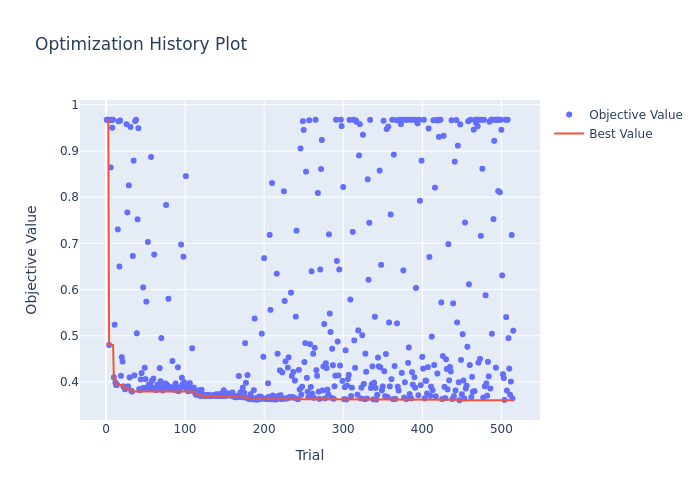

In [12]:
plot_optimization_history(study)

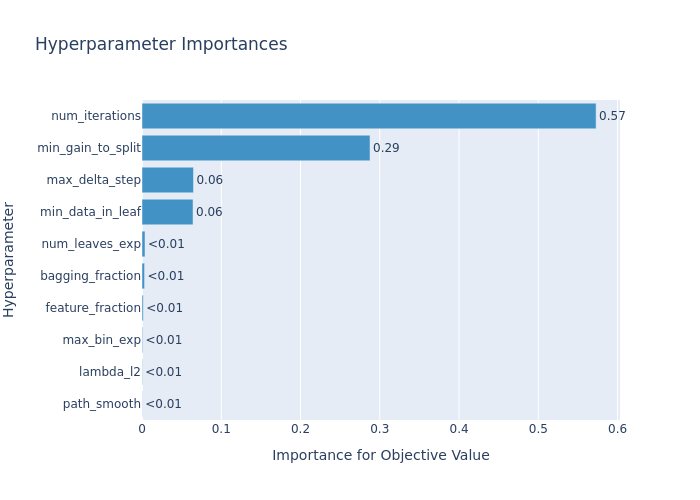

In [13]:
plot_param_importances(study)

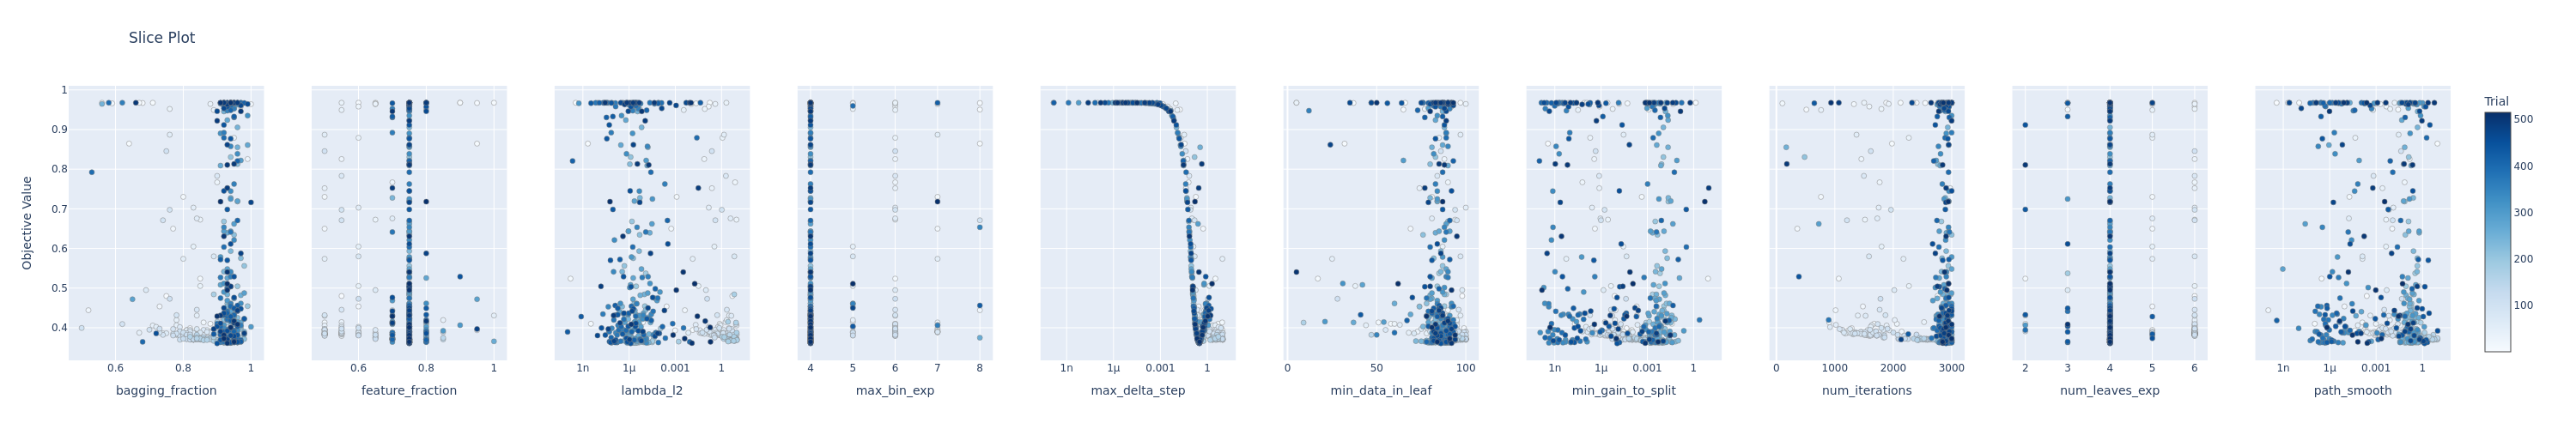

In [14]:
plot_slice(study)

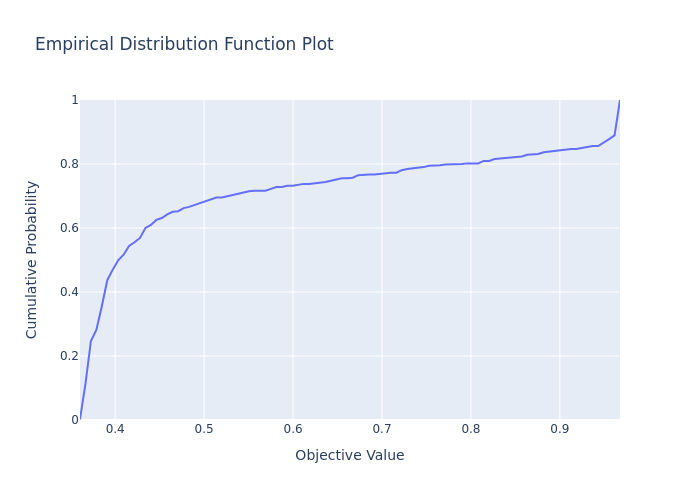

In [15]:
plot_edf(study)

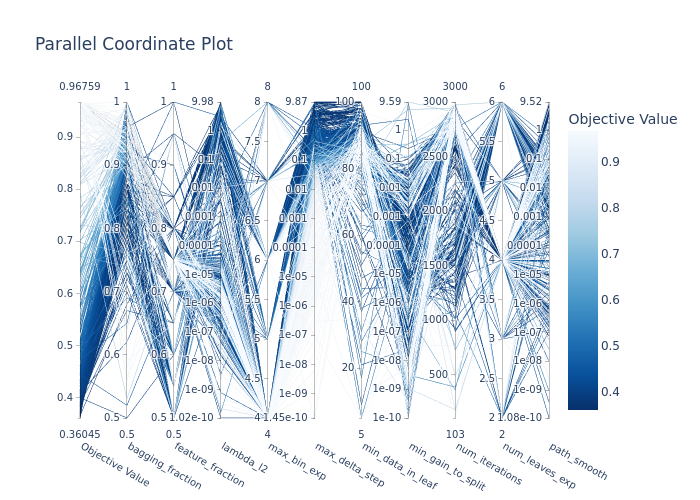

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'multiclass',
 'num_class': 4,
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_fraction': 0.9,
 'feature_fraction': 0.75,
 'lambda_l2': 1.2658399920443532e-06,
 'max_delta_step': 0.31199364935886675,
 'min_data_in_leaf': 86,
 'min_gain_to_split': 1.0966390624205353e-05,
 'num_iterations': 2902,
 'path_smooth': 1.3552303496694738,
 'max_bin': 15,
 'num_leaves': 15}

***